<p style="text-align: center; font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;">
LoRaWAN Indoor Distance estimation via Log-Distance Path Loss & Shadow Modeling: Kalman Filtering and MLR
</p>

# Overview

This notebook presents an end-to-end framework for enhancing wireless localization through advanced signal processing and propagation modeling. We tackle the inherent noise in Received Signal Strength Indicator (RSSI) measurements by applying a one-dimensional [Kalman filter](https://ani.stat.fsu.edu/~jfrade/HOMEWORKS/STA5107/presentation/sta5107-present/Kalman%20Filter/papers/kalman.pdf) — a recursive Bayesian estimator introduced by Kalman (1960). The filtered RSSI values are then used to calibrate robust [COST231](https://op.europa.eu/en/publication-detail/-/publication/f2f42003-4028-4496-af95-beaa38fd475f) path loss models that account for both structural and environmental influences on signal propagation.

**Key components of this notebook include:**

- **Data Preprocessing & Visualization:**  
  We load a comprehensive dataset of sensor measurements, perform an 80-20 stratified train-test split, and visualize the effect of Kalman filtering on RSSI data across multiple devices.

- **Kalman Filtering:**  
  A detailed cell implements the Kalman filter using the `pykalman` library. The full state-space equations are:
  
  $$
  \begin{aligned}
  x_{k} &= x_{k-1} + w_{k}, \quad w_{k} \sim \mathcal{N}(0, Q), \\
  z_{k} &= x_{k} + v_{k}, \quad v_{k} \sim \mathcal{N}(0, R),
  \end{aligned}
  $$
  
  where $x_k$ represents the latent RSSI and $z_k$ is the observed signal.

- **Path Loss Modeling & Distance Estimation:**  
  We extend the classical log-distance equation under the COST231 model for a single-floor scenario by incorporating wall losses as a summation over categorical wall types. The extended model is:

  $$
  PL(d) = PL(d_0) + 10\,n\,\log_{10}\!\left(\frac{d}{d_0}\right) + \sum_{i=1}^{K} W_i\,L_i + \epsilon,
  $$

  where:
  - $PL(d_0)$ is the reference path loss at a close-in distance $d_0$,
  - $n$ is the path loss exponent,
  - $d$ is the distance,
  - $K$ is the total number of distinct wall categories (e.g., concrete, wooden),
  - $W_i$ is the count of walls of type $i$,
  - $L_i$ is the attenuation factor for wall type $i$, and
  - $\epsilon$ captures the random shadowing effects.

  
  which is later extended to incorporate additional dynamic environmental parameters (e.g., temperature, humidity, etc.).

- **Model Evaluation & Visualization:**  
  Finally, we compare model performance (using metrics such as RMSE, $R^2$, and the standard deviation of shadowing) across raw and filtered RSSI inputs. Visualizations include scatter plots, histograms, and cumulative distribution functions (CDFs) to assess the models' predictive capabilities.


In [118]:
  # Standard Library Imports
import io                          # In-memory stream handling
import contextlib                  # Context manager utilities

  # Data Manipulation
import pandas as pd                # Data structures & analysis
import numpy as np                 # Numerical computations

  # Data Visualization
import matplotlib.pyplot as plt    # Plotting library
import seaborn as sns              # Statistical data visualization
import matplotlib.ticker as ticker # Custom tick formatting
from matplotlib.ticker import MaxNLocator  # Fine-grained tick control
import matplotlib.dates as mdates  # Date formatting for plots
import matplotlib.patches as mpatches  # Shape and legend patches

  # Machine Learning
from sklearn.model_selection import train_test_split  # Data splitting
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score  # Model evaluation

  # Time Series Analysis
from statsmodels.tsa.seasonal import STL              # Seasonal decomposition
from statsmodels.tsa.stattools import grangercausalitytests  # Causality testing
from statsmodels.tsa.vector_ar.var_model import VAR    # Vector Autoregression (VAR)

  # Signal Processing
from pykalman import KalmanFilter                     # Kalman filtering
from scipy.optimize import curve_fit                  # Curve fitting

# ----------------------------
# Set global Seaborn style (dark grid)
# ----------------------------
sns.set_style("darkgrid")
sns.set_context("talk", font_scale=0.9)

In [119]:
# Load data and convert time column
df = pd.read_csv('../all_data_files/cleaned_dataset_per_device.csv')
df['time'] = pd.to_datetime(df['time'])
df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2079534 entries, 0 to 2079533
Data columns (total 20 columns):
 #   Column       Dtype              
---  ------       -----              
 0   time         datetime64[ns, UTC]
 1   device_id    object             
 2   co2          float64            
 3   humidity     float64            
 4   pm25         float64            
 5   pressure     float64            
 6   temperature  float64            
 7   rssi         float64            
 8   snr          float64            
 9   SF           int64              
 10  frequency    float64            
 11  f_count      float64            
 12  p_count      float64            
 13  toa          float64            
 14  distance     int64              
 15  c_walls      int64              
 16  w_walls      int64              
 17  exp_pl       float64            
 18  n_power      float64            
 19  esp          float64            
dtypes: datetime64[ns, UTC](1), float64(14), int64(

,time,device_id,co2,humidity,pm25,pressure,temperature,rssi,snr,SF,frequency,f_count,p_count,toa,distance,c_walls,w_walls,exp_pl,n_power,esp
0,2024-10-01 00:01:07.420593+00:00,ED5,440.0,45.46,0.46,313.80,22.41,-102.0,10.2,9,868.1,9868.0,10756.0,0.246784,40,2,2,119.26,-112.596121,-102.396121
1,2024-10-01 00:01:25.764905+00:00,ED2,451.0,40.59,0.43,314.81,22.83,-66.0,11.0,10,867.9,5815.0,6642.0,0.452608,23,0,2,83.26,-77.331956,-66.331956
2,2024-10-01 00:01:50.313519+00:00,ED4,435.0,37.33,0.05,315.54,24.06,-119.0,-1.8,10,867.1,9335.0,10753.0,0.452608,37,0,5,136.26,-121.202895,-123.002895
3,2024-10-01 00:02:07.467816+00:00,ED5,449.0,45.43,0.40,313.84,22.41,-100.0,10.8,9,867.7,9869.0,10757.0,0.246784,40,2,2,117.26,-111.146992,-100.346992
4,2024-10-01 00:02:25.817808+00:00,ED2,451.0,40.57,0.21,314.80,22.84,-64.0,8.8,10,867.7,5816.0,6643.0,0.452608,23,0,2,81.26,-73.337795,-64.537795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2079529,2025-09-30 23:59:20.436955+00:00,ED1,765.0,43.17,1.32,332.23,22.95,-49.0,11.8,8,867.1,127208.0,127506.0,0.133632,8,1,0,66.26,-61.077855,-49.277855
2079530,2025-09-30 23:59:33.711547+00:00,ED4,626.0,37.18,0.28,333.20,24.63,-90.0,12.8,9,867.1,126741.0,127512.0,0.246784,37,0,5,107.26,-103.022142,-90.222142
2079531,2025-09-30 23:59:51.442628+00:00,ED3,725.0,48.96,1.91,331.95,20.43,-60.0,12.2,8,867.9,117189.0,117586.0,0.133632,18,1,2,77.26,-72.454107,-60.254107
2079532,2025-09-30 23:59:54.616737+00:00,ED5,493.0,46.30,3.16,331.90,22.49,-94.0,10.8,9,868.3,127147.0,127514.0,0.246784,40,2,2,111.26,-105.146992,-94.346992


In [120]:
# 80-20 stratified train-test split ensuring all 6 devices are included in both sets
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['device_id'], random_state=200)

# Sort by time for clarity in plotting
train_df = train_df.sort_values('time')
test_df = test_df.sort_values('time')

## STL Decomposition and Granger Causality Test
### Per Parameter Analysis

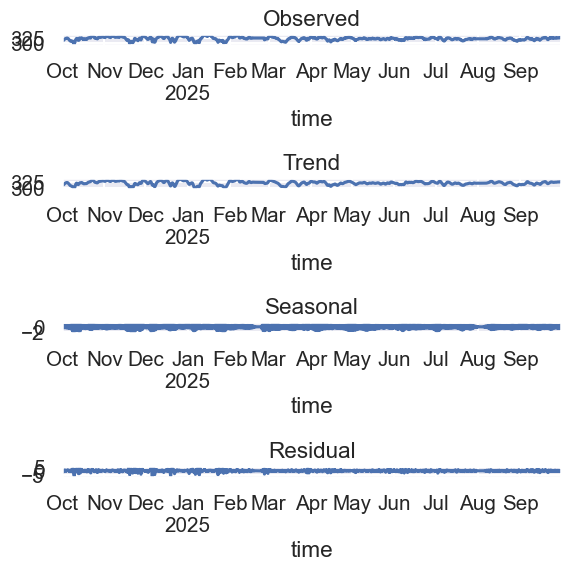

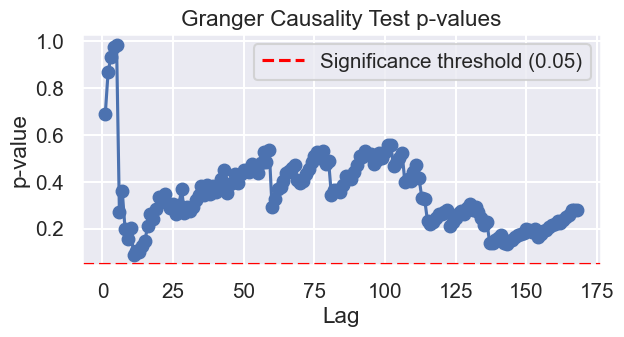


For pressure: 

Minimum p-value is 0.0888 at lag 11.
No significant Granger causality detected.



In [121]:
# Set the parameter to analyse
param = 'pressure'

# -----------------------------
# Decompose time series for the given parameter
# -----------------------------
param_series = train_df.set_index('time')[param].resample('1h').mean().ffill()
stl = STL(param_series, period=24).fit()  # period=24 for daily seasonality in hourly data

# Plot STL decomposition
fig, ax = plt.subplots(4, 1, figsize=(6, 6))
stl.observed.plot(ax=ax[0], title='Observed')
stl.trend.plot(ax=ax[1], title='Trend')
stl.seasonal.plot(ax=ax[2], title='Seasonal')
stl.resid.plot(ax=ax[3], title='Residual')
plt.tight_layout()
plt.show()

# -----------------------------
# Prepare data for Granger causality test
# -----------------------------
gc_data = pd.DataFrame({
    'RSSI': train_df.groupby(pd.Grouper(key='time', freq='1h'))['rssi'].mean(),
    param: param_series
}).dropna()

# -----------------------------
# Run Granger causality test and capture output
# -----------------------------
with contextlib.redirect_stdout(io.StringIO()):
    gc_results = grangercausalitytests(gc_data[['RSSI', param]], maxlag=168)

# -----------------------------
# Extract p-values and plot them
# -----------------------------
lags = range(1,169)  # lags 1 to 168
p_values = []

for lag in lags:
    # Extract p-value from the SSR-based F test.
    p = gc_results[lag][0]['ssr_ftest'][1]
    p_values.append(p)

# Plot p-values vs. lags
plt.figure(figsize=(6.7, 3))
plt.plot(list(lags), p_values, marker='o')
plt.axhline(y=0.05, color='red', linestyle='--', label='Significance threshold (0.05)')
plt.xlabel('Lag')
plt.ylabel('p-value')
plt.title('Granger Causality Test p-values')
plt.legend()
plt.grid(True)
plt.show()

# -----------------------------
# Summary analysis: determine the minimum p-value across all lags
# -----------------------------
lag_pvalues = {lag: gc_results[lag][0]['ssr_ftest'][1] for lag in lags}
min_pvalue = min(lag_pvalues.values())
min_lag = min(lag_pvalues, key=lag_pvalues.get)
print(f"\nFor {param}: \n\nMinimum p-value is {min_pvalue:.4f} at lag {min_lag}.")

if min_pvalue < 0.05:
    print("There is evidence of Granger causality.\n")
else:
    print("No significant Granger causality detected.\n")

#### STL Decomposition

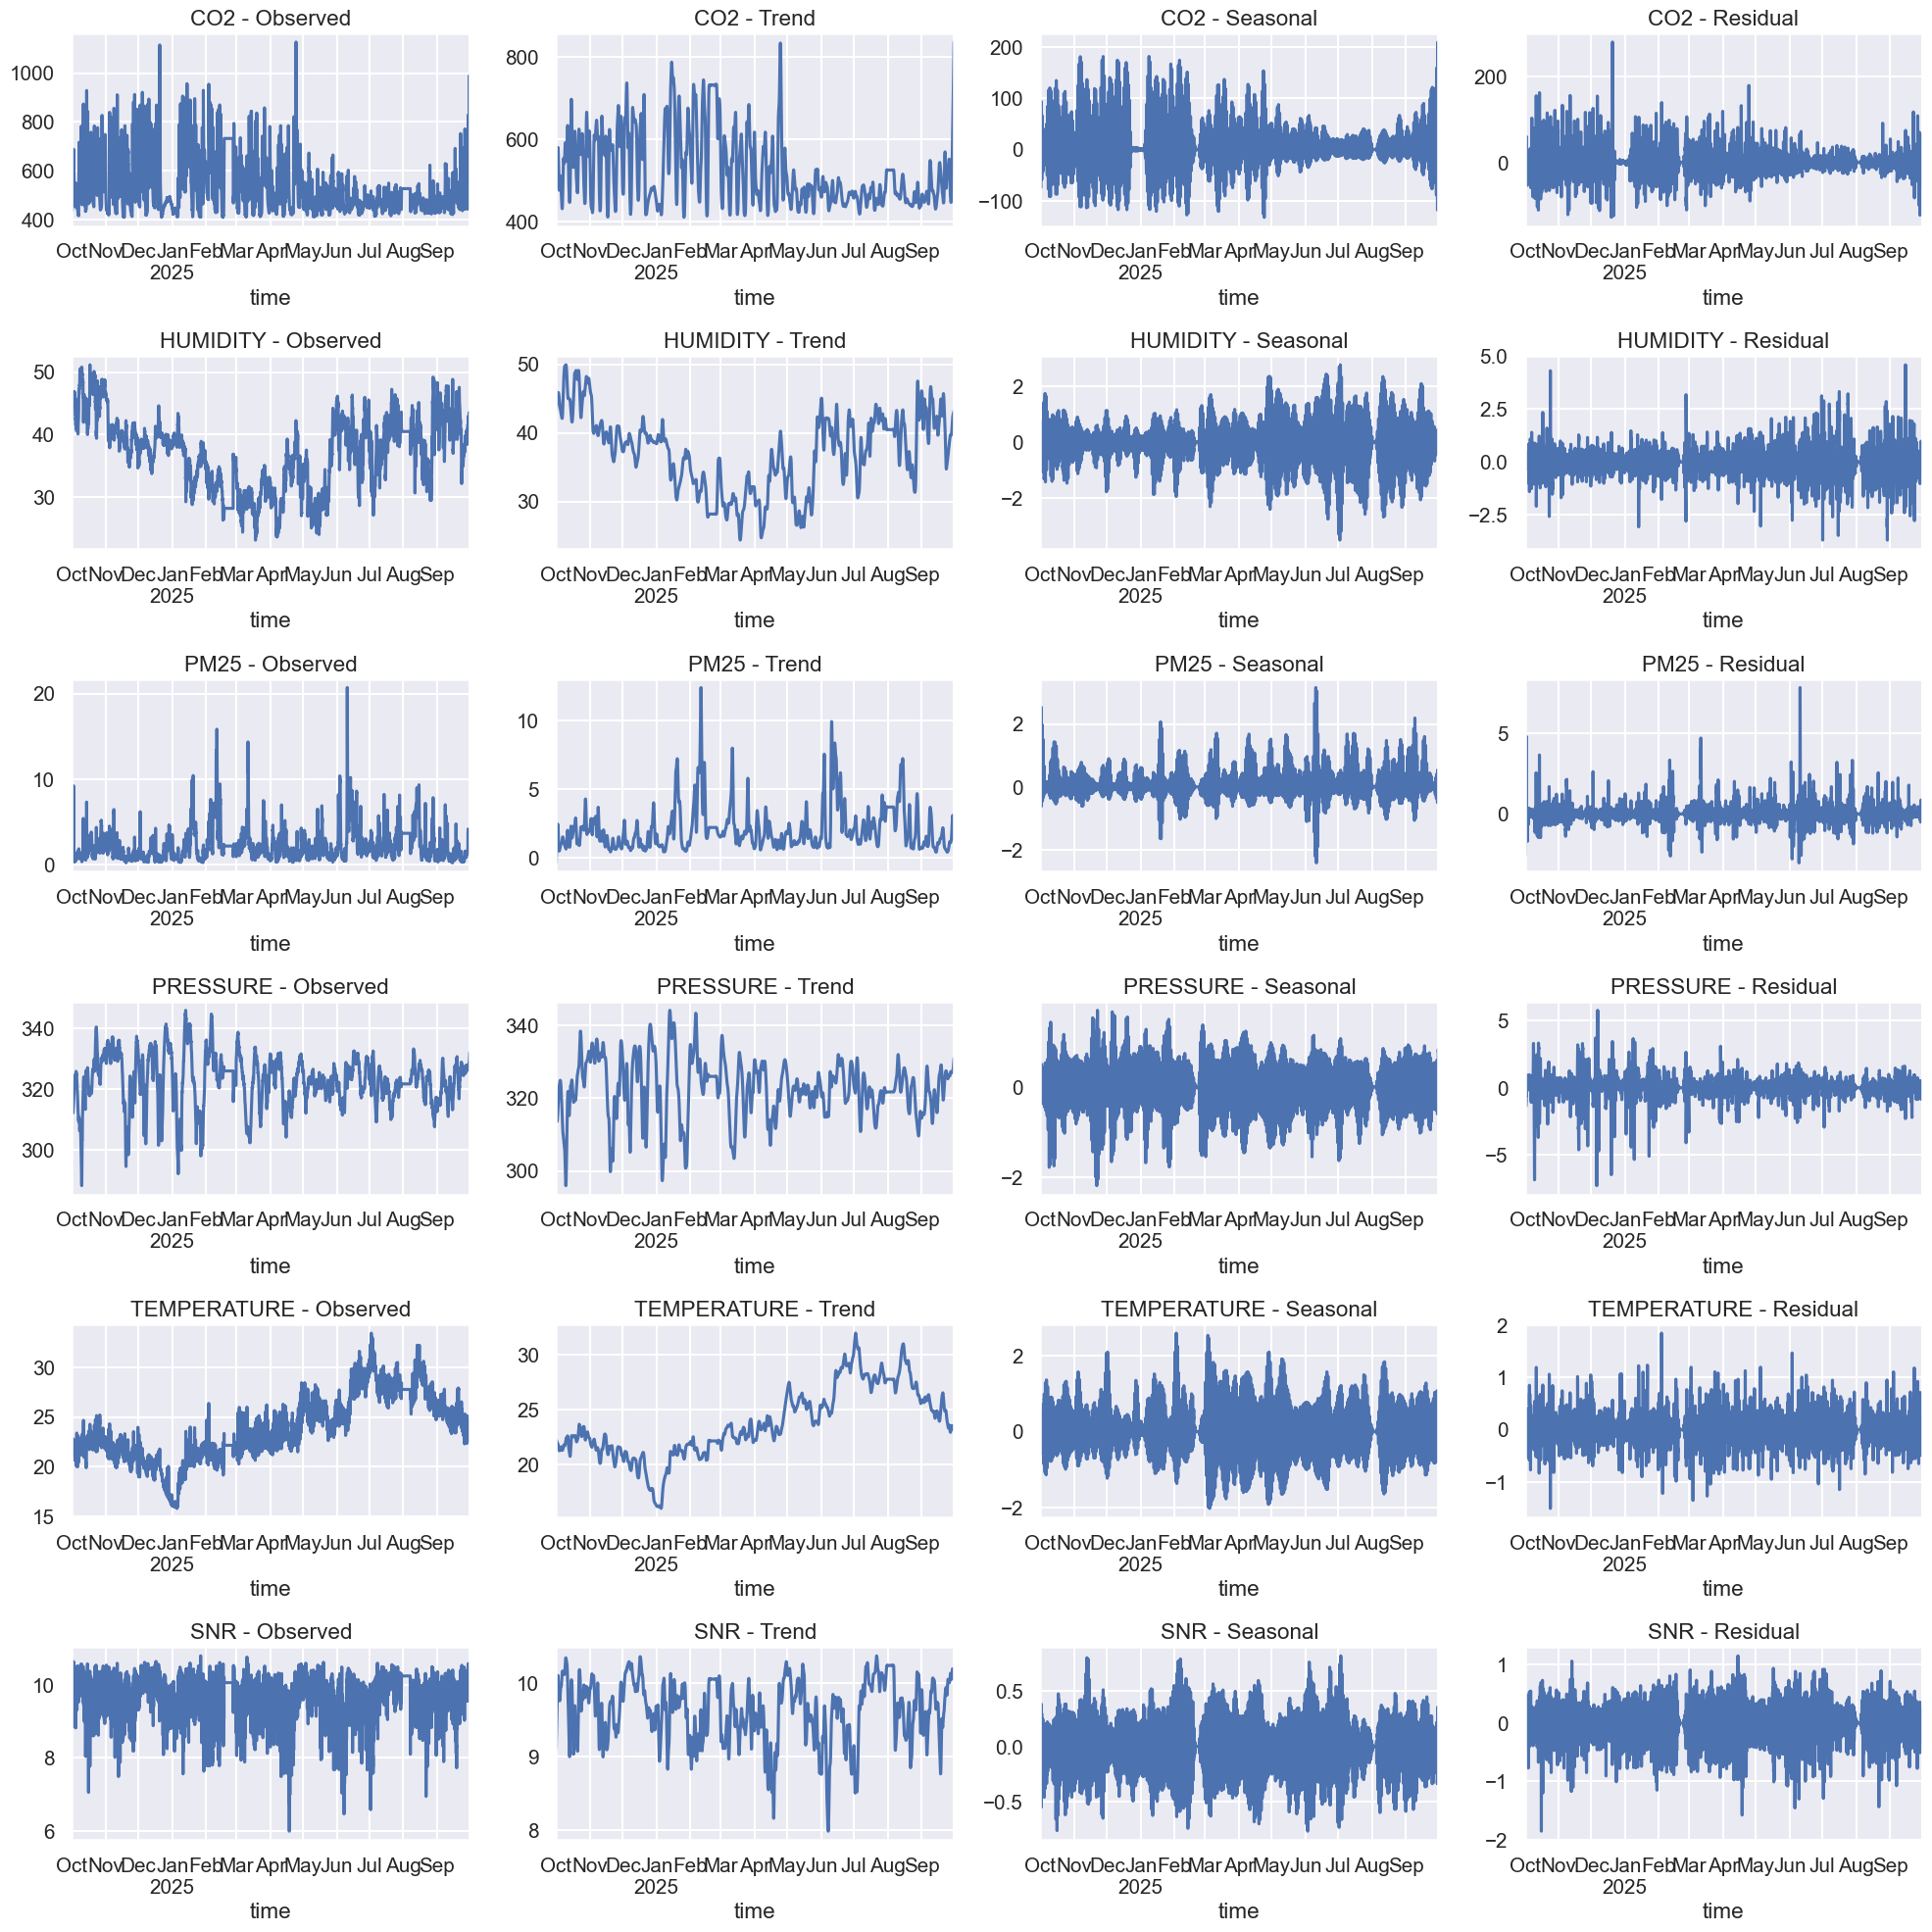

In [122]:
# List of parameters to analyze
parameters = ['co2', 'humidity', 'pm25', 'pressure', 'temperature', 'snr']

# Create a figure with 6 rows and 4 columns for subplots
fig, axes = plt.subplots(nrows=6, ncols=4, figsize=(20, 20))  # We can adjust figure size as needed

# Loop over each parameter to perform STL decomposition and plot the 4 components on the corresponding row.
for i, param in enumerate(parameters):
    # Resample the time series (hourly mean) and fill missing values
    ts = train_df.set_index('time')[param].resample('1h').mean().ffill()
    
    # Perform STL decomposition with daily seasonality (period=24)
    stl = STL(ts, period=24).fit()
    
    # Plot each component in the appropriate column
    stl.observed.plot(ax=axes[i, 0], title=f'{param.upper()} - Observed')
    stl.trend.plot(ax=axes[i, 1], title=f'{param.upper()} - Trend')
    stl.seasonal.plot(ax=axes[i, 2], title=f'{param.upper()} - Seasonal')
    stl.resid.plot(ax=axes[i, 3], title=f'{param.upper()} - Residual')

plt.tight_layout()
plt.show()

#### Granger Causality Test

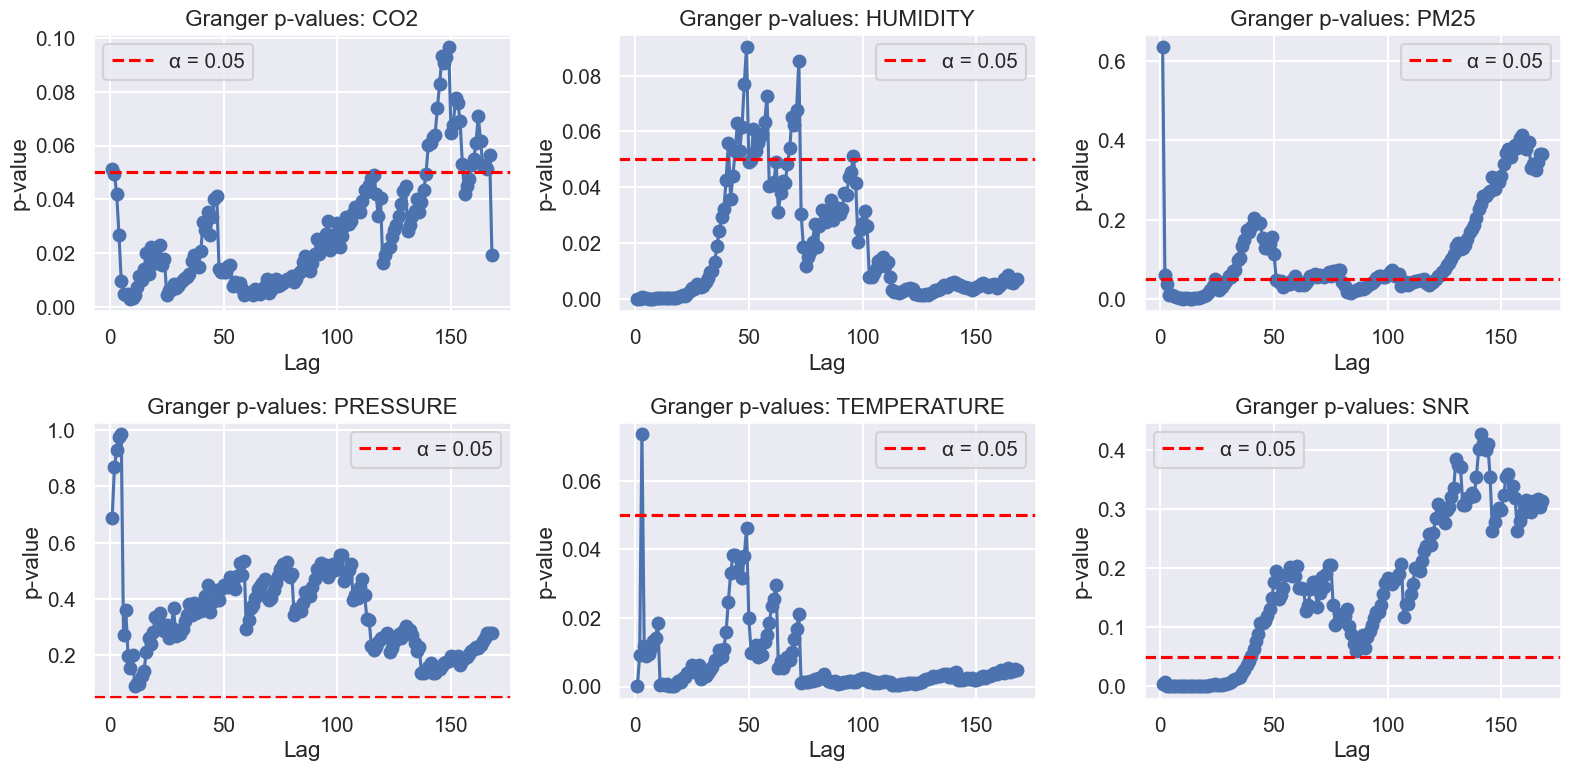


Granger Causality Summary (RSSI vs Parameter):



,Parameter,Min p-value,Lag,Evidence
0,CO2,0.003153,9,Yes
1,HUMIDITY,0.0,1,Yes
2,PM25,0.000776,13,Yes
3,PRESSURE,0.08881,11,No
4,TEMPERATURE,0.000013,1,Yes
5,SNR,0.000001,10,Yes


In [123]:
# Prepare a figure grid for p-value plots: 2 rows x 3 columns for our six parameters.
fig, axes = plt.subplots(2, 3, figsize=(16, 8))
axes = axes.flatten()

# Dictionary to store summary results for each parameter
summary_results = {}

# List of parameters
for i, param in enumerate(parameters):
    # Resample RSSI and the parameter (hourly mean)
    rssi_ts = train_df.groupby(pd.Grouper(key='time', freq='1h'))['rssi'].mean()
    param_ts = train_df.groupby(pd.Grouper(key='time', freq='1h'))[param].mean()
    
    # Create a DataFrame for the two series and drop missing values
    gc_data = pd.DataFrame({'RSSI': rssi_ts, param.upper(): param_ts}).dropna()
    
    # Run Granger causality tests with output suppressed, using maxlag = 6
    with contextlib.redirect_stdout(io.StringIO()):
        gc_results = grangercausalitytests(gc_data[['RSSI', param.upper()]], maxlag=168)
    
    # Extract p-values (using ssr-based F test) for lags 1 to 168
    lags = range(1, 169)
    p_values = []
    lag_pvalues = {}
    for lag in lags:
        p_val = gc_results[lag][0]['ssr_ftest'][1]
        p_values.append(p_val)
        lag_pvalues[lag] = p_val
    
    # Plot p-values vs. lag on the corresponding subplot
    ax = axes[i]
    ax.plot(list(lags), p_values, marker='o')
    ax.axhline(y=0.05, color='red', linestyle='--', label='α = 0.05')
    ax.set_xlabel('Lag')
    ax.set_ylabel('p-value')
    ax.set_title(f'Granger p-values: {param.upper()}')
    ax.legend()
    ax.grid(True)
    
    # Determine the minimum p-value and corresponding lag
    min_p = min(lag_pvalues.values())
    min_lag = min(lag_pvalues, key=lag_pvalues.get)
    summary_results[param.upper()] = {'Min p-value': min_p, 'Lag': min_lag,
                                      'Evidence': 'Yes' if min_p < 0.05 else 'No'}

plt.tight_layout()
plt.show()

# Convert the summary_results dictionary into a DataFrame for a neat table display
summary_df = pd.DataFrame(summary_results).T  # transpose so each parameter is a row
summary_df.index.name = 'Parameter'
summary_df.reset_index(inplace=True)

# Display summary table: each row shows the minimum p-value, corresponding lag,
# and whether evidence of Granger causality was found (using threshold α=0.05).
print("\nGranger Causality Summary (RSSI vs Parameter):\n")
display(summary_df)

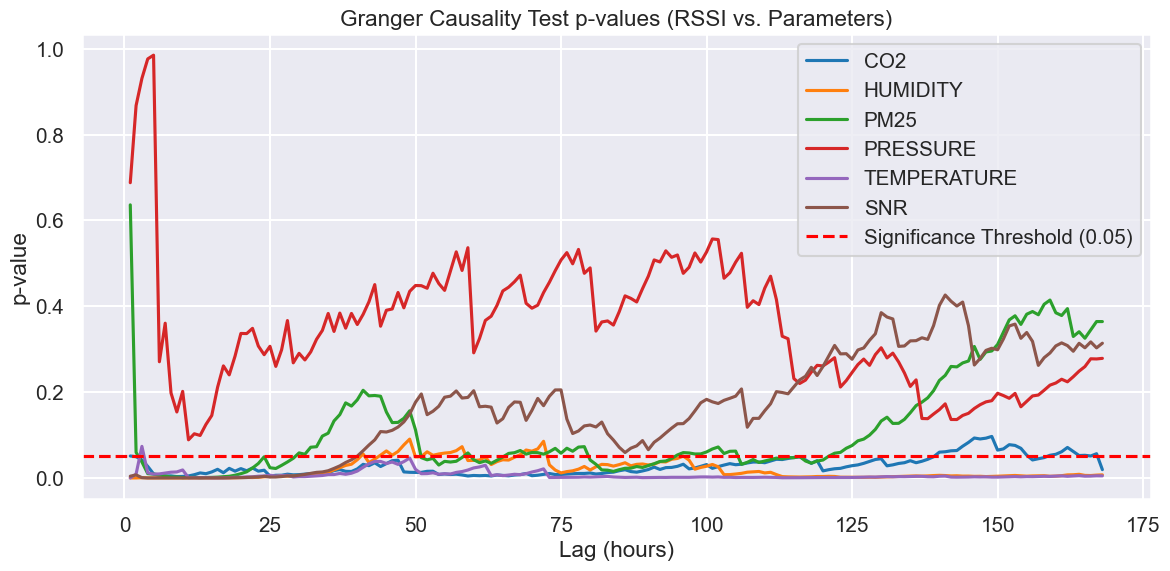


Granger Causality Summary (RSSI vs Parameter):



,Parameter,Min p-value,Lag,Evidence
0,CO2,0.003153,9,Yes
1,HUMIDITY,0.0,1,Yes
2,PM25,0.000776,13,Yes
3,PRESSURE,0.08881,11,No
4,TEMPERATURE,0.000013,1,Yes
5,SNR,0.000001,10,Yes


In [124]:
# List of parameters to analyze
parameters = ['co2', 'humidity', 'pm25', 'pressure', 'temperature', 'snr']

# Create a single figure for all p-value curves.
plt.figure(figsize=(12, 6))

# Use a colormap to cycle through distinct colors (here, tab10 has 10 distinct colors)
colors = plt.cm.tab10.colors  

# Dictionary to store summary results for each parameter
summary_results = {}

# Loop over each parameter.
for i, param in enumerate(parameters):
    # Resample RSSI and the parameter (hourly mean)
    rssi_ts = train_df.groupby(pd.Grouper(key='time', freq='1h'))['rssi'].mean()
    param_ts = train_df.groupby(pd.Grouper(key='time', freq='1h'))[param].mean()
    
    # Create a DataFrame for the two series and drop missing values
    gc_data = pd.DataFrame({'RSSI': rssi_ts, param.upper(): param_ts}).dropna()
    
    # Run Granger causality tests with output suppressed, using maxlag = 168 (one week for hourly data)
    with contextlib.redirect_stdout(io.StringIO()):
        gc_results = grangercausalitytests(gc_data[['RSSI', param.upper()]], maxlag=168)
    
    # Extract p-values (using ssr-based F test) for lags 1 to 168
    lags = range(1, 169)
    p_values = []
    lag_pvalues = {}
    for lag in lags:
        p_val = gc_results[lag][0]['ssr_ftest'][1]
        p_values.append(p_val)
        lag_pvalues[lag] = p_val
    
    # Plot the p-values vs. lag for the current parameter using a distinct color
    plt.plot(list(lags), p_values, label=param.upper(), color=colors[i % len(colors)])
    
    # Determine the minimum p-value and corresponding lag for summary analysis
    min_p = min(lag_pvalues.values())
    min_lag = min(lag_pvalues, key=lag_pvalues.get)
    summary_results[param.upper()] = {'Min p-value': min_p, 'Lag': min_lag,
                                      'Evidence': 'Yes' if min_p < 0.05 else 'No'}

# Draw the significance threshold line at 0.05
plt.axhline(y=0.05, color='red', linestyle='--', label='Significance Threshold (0.05)')

# Configure plot aesthetics
plt.xlabel('Lag (hours)')
plt.ylabel('p-value')
plt.title('Granger Causality Test p-values (RSSI vs. Parameters)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Convert the summary_results dictionary into a DataFrame for a neat table display
summary_df = pd.DataFrame(summary_results).T  # transpose so each parameter is a row
summary_df.index.name = 'Parameter'
summary_df.reset_index(inplace=True)

# Display summary table: each row shows the minimum p-value, corresponding lag,
# and whether evidence of Granger causality was found (using threshold α = 0.05).
print("\nGranger Causality Summary (RSSI vs Parameter):\n")
display(summary_df)

### Multivariate Vector Autoregression (VAR) Analysis of RSSI and Environmental Predictors

This section implements a full multivariate VAR pipeline to investigate dynamic relationships between RSSI and multiple environmental variables (`CO₂`, `Humidity`, `PM2.5`, `Pressure`, `Temperature`, and `SNR`). The key steps and outputs include:

- **Data Resampling & Preprocessing**: Hourly averages with forward fill for gaps.
- **Lag Order Selection**: Automatically selected using AIC from up to 24 lags.
- **VAR Model Fitting**: Using the optimal lag order.
- **Granger Causality Tests**: Assessing directional influence between RSSI and predictors.
- **Impulse Response Functions (IRFs)**:
  - Visualized in 2×3 subplots.
  - Include 95% confidence bands.
  - Show RSSI's response to one-unit shocks in each predictor over a 10-hour horizon.
- **Forecast Error Variance Decomposition (FEVD)**:
  - Shows how much of RSSI's forecast error variance is attributable to each predictor.
- **Summary Outputs**:
  - Lag selection table.
  - Residual correlation matrix.
  - Compact Granger test summaries.
  - IRF and FEVD plots.
  - Final insights for interpretation.

NOTE: No verbose per-variable regression summaries are printed.

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        20.52       20.52   8.129e+08       20.52
1       -4.319      -4.273     0.01332      -4.303
2       -5.864      -5.779    0.002840      -5.835
3       -5.987     -5.862*    0.002511      -5.945
4       -6.018      -5.853    0.002436      -5.961
5       -6.040      -5.836    0.002381      -5.971
6       -6.050      -5.806    0.002357      -5.967
7       -6.065      -5.782    0.002323      -5.968
8       -6.080      -5.757    0.002288      -5.970
9       -6.094      -5.731    0.002256      -5.970
10      -6.109      -5.707    0.002222      -5.972
11      -6.120      -5.678    0.002199      -5.969
12      -6.135      -5.653    0.002166      -5.971
13      -6.161      -5.639    0.002111      -5.983
14      -6.175      -5.613    0.002081      -5.983
15      -6.192      -5.591    0.002045      -5.987
16      -6.215      -5.575    0

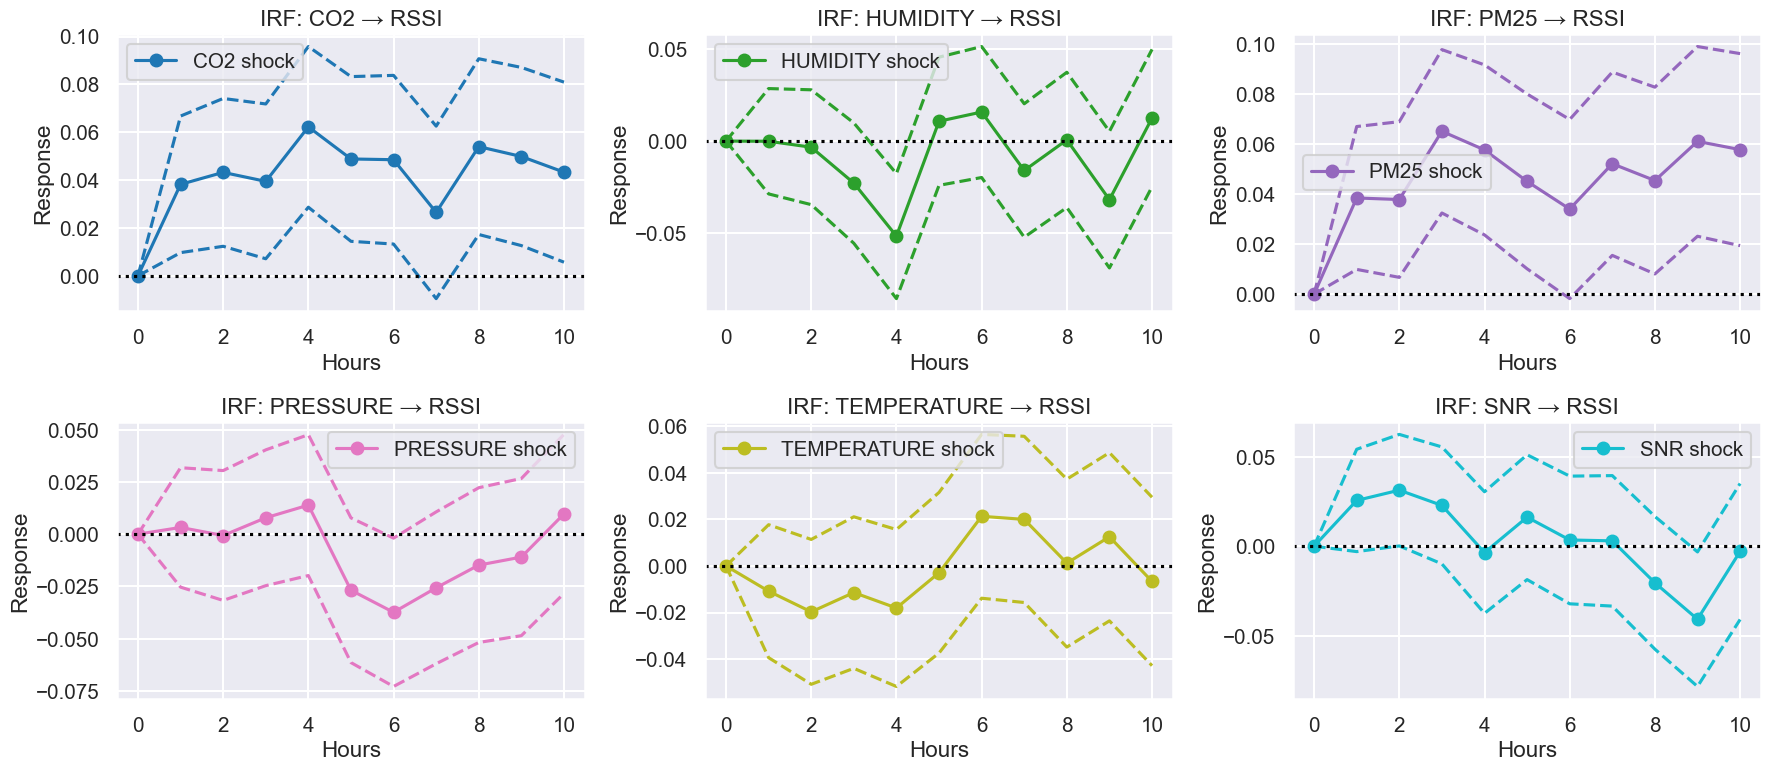

C:\Users\nahsh\AppData\Local\Temp\ipykernel_20592\419098441.py:109: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


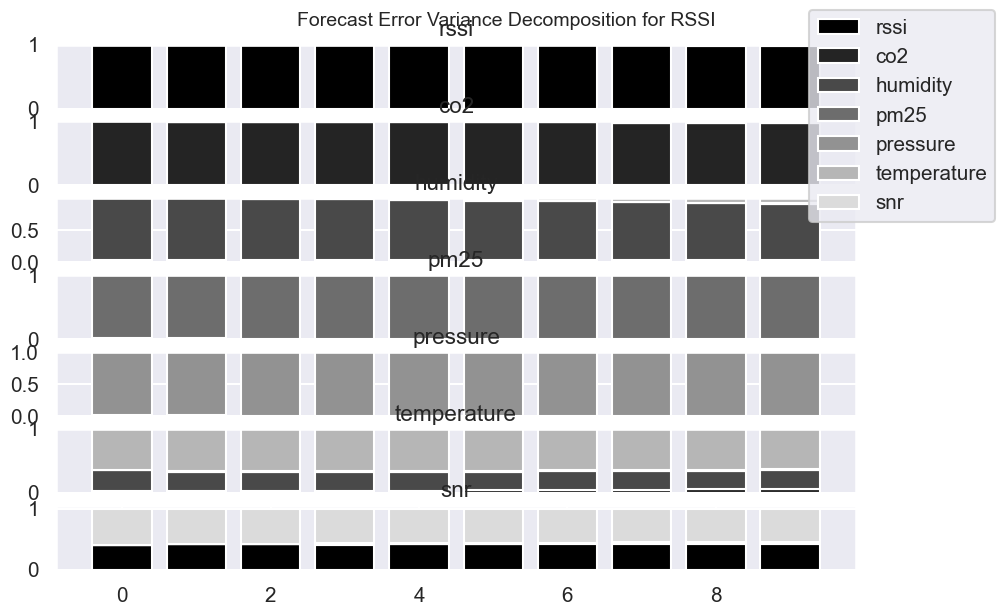

Final Insights:
- The VAR model (lag order = 24) shows that hourly data from the past 24 hours are relevant.
- Granger causality tests reveal statistically significant bidirectional relationships between RSSI and the predictors.
- The IRF subplots (with 95% confidence intervals) show the dynamic response of RSSI to shocks in each predictor over a 10-hour horizon.
- The FEVD plot indicates the proportion of RSSI's forecast error variance attributed to shocks in each predictor.
- Overall, the system dynamics are highly interdependent, confirming the need for a multivariate modeling approach.


In [125]:
# ========= Data Preparation =========
cols = ['rssi', 'co2', 'humidity', 'pm25', 'pressure', 'temperature', 'snr']
data = train_df.set_index('time')[cols].resample('1h').mean().ffill()

# ========= VAR Model Estimation =========
model = VAR(data)
lag_order_results = model.select_order(maxlags=24)
selected_lag = lag_order_results.aic

# Print lag order selection and selected lag order.
print(lag_order_results.summary())
print(f"Selected lag order by AIC: {selected_lag}\n")

# Fit the VAR model using the selected lag order.
var_results = model.fit(selected_lag)
# Do not print the full VAR model summary to avoid excessively detailed output.
print("VAR model fit completed.\n")

# Print the correlation matrix of residuals.
resid_corr = pd.DataFrame(var_results.resid, columns=var_results.names).corr()
print("Correlation matrix of residuals:")
print(resid_corr, "\n")

# ========= Granger Causality Tests =========
# Predictors → RSSI:
gc_test_pred_to_rssi = var_results.test_causality(
    caused='rssi',
    causing=['co2', 'humidity', 'pm25', 'pressure', 'temperature', 'snr'],
    kind='wald'
)
print("Granger Causality Test (Predictors → RSSI):")
print(gc_test_pred_to_rssi.summary())
print("\n")

# RSSI → Predictors:
gc_test_rssi_to_pred = var_results.test_causality(
    caused=['co2', 'humidity', 'pm25', 'pressure', 'temperature', 'snr'],
    causing='rssi',
    kind='wald'
)
print("Granger Causality Test (RSSI → Predictors):")
print(gc_test_rssi_to_pred.summary())
print("\n")

# ========= Impulse Response Functions (IRF) with Subplots =========
horizon = 10
irf = var_results.irf(horizon)  # Obtain the IRF object.

# Attempt to extract the orthogonalized IRFs with confidence intervals.
# Newer versions of statsmodels provide these attributes; if not, we extract via temporary plots.
try:
    center_irfs = irf.orth_irfs
    lower_irfs = irf.orth_irfs_lower
    upper_irfs = irf.orth_irfs_upper
except AttributeError:
    # If lower and upper bounds are unavailable, then use the built-in plots to extract data.
    # (This block is rarely needed with a current statsmodels version.)
    center_irfs = irf.orth_irfs
    lower_irfs = None
    upper_irfs = None

names = var_results.names  # e.g. ['rssi','co2','humidity','pm25','pressure','temperature','snr']
response_var = 'rssi'
predictors = ['co2', 'humidity', 'pm25', 'pressure', 'temperature', 'snr']

# Create a 2×3 grid of subplots.
fig_irf, axes = plt.subplots(2, 3, figsize=(18, 8))
axes = axes.flatten()
time_axis = np.arange(0, horizon+1)
colors = plt.cm.tab10(np.linspace(0, 1, len(predictors)))

for i, impulse_var in enumerate(predictors):
    impulse_idx = names.index(impulse_var)
    response_idx = names.index(response_var)
    ax = axes[i]
    if lower_irfs is not None and upper_irfs is not None:
        center = center_irfs[:, response_idx, impulse_idx]
        lower  = lower_irfs[:, response_idx, impulse_idx]
        upper  = upper_irfs[:, response_idx, impulse_idx]
        ax.plot(time_axis, center, color=colors[i], marker='o', label=f"{impulse_var.upper()} shock")
        ax.plot(time_axis, lower, color=colors[i], linestyle='--')
        ax.plot(time_axis, upper, color=colors[i], linestyle='--')
    else:
        # Fallback: use built-in irf.plot() and extract data.
        with contextlib.redirect_stdout(io.StringIO()):
            temp_fig = irf.plot(impulse=impulse_var, response=response_var, orth=True, figsize=(6,4))
        ax_temp = temp_fig.axes[0]
        lines = ax_temp.get_lines()
        x_main, y_main = lines[0].get_data()
        x_lower, y_lower = lines[1].get_data()
        x_upper, y_upper = lines[2].get_data()
        ax.plot(x_main, y_main, color=colors[i], marker='o', label=f"{impulse_var.upper()} shock")
        ax.plot(x_lower, y_lower, color=colors[i], linestyle='--')
        ax.plot(x_upper, y_upper, color=colors[i], linestyle='--')
        plt.close(temp_fig)
    ax.axhline(0, color='black', linestyle=':')
    ax.set_title(f"IRF: {impulse_var.upper()} → {response_var.upper()}")
    ax.set_xlabel("Hours")
    ax.set_ylabel("Response")
    ax.legend()

plt.tight_layout()
plt.show()

# ========= Forecast Error Variance Decomposition (FEVD) =========
fevd = var_results.fevd(horizon)
fig_fevd = fevd.plot(figsize=(10, 6))  # Plots FEVD for all variables.
plt.suptitle("Forecast Error Variance Decomposition for RSSI", fontsize=14)
plt.tight_layout()
plt.show()

# ========= Final Insights Summary =========
print("Final Insights:")
print(f"- The VAR model (lag order = {selected_lag}) shows that hourly data from the past 24 hours are relevant.")
print("- Granger causality tests reveal statistically significant bidirectional relationships between RSSI and the predictors.")
print("- The IRF subplots (with 95% confidence intervals) show the dynamic response of RSSI to shocks in each predictor over a 10-hour horizon.")
print("- The FEVD plot indicates the proportion of RSSI's forecast error variance attributed to shocks in each predictor.")
print("- Overall, the system dynamics are highly interdependent, confirming the need for a multivariate modeling approach.")

###  Kalman Filtering

Kalman filtering provides an optimal estimation framework for linear systems corrupted by Gaussian noise.
The filter recursively computes the predicted state and its uncertainty, then updates these estimates with new observations through:

$$
K_k = \frac{P_{k|k-1}}{P_{k|k-1} + R}, \quad \hat{x}_k = \hat{x}_{k|k-1} + K_k (z_k - \hat{x}_{k|k-1})
$$

where $K_k$ is the Kalman gain and $P_{k|k-1}$ is the predicted covariance. This methodology mitigates transient measurement anomalies and refines the quality of the RSSI input for subsequent modeling tasks.


In [126]:
# ------------------ Self‑tuning 1D Kalman filter for RSSI ------------------
def adaptive_kf_rssi(z,
                     Q_init=0.003,       #  drift control (~0.055 dB)
                     R_init=0.22,        # leaner measurement noise (~0.47 dB std)
                     gamma_min=0.95,     # allow R to shrink by 5%
                     gamma_max=1.05,     # allow it to inflate by 5% at most
                     forget_factor=0.99, # smooth adaptation over ~100 samples
                     R_guard=(0.12,0.38),# clamp R to [0.12,0.38] for stability
                     adapt_Q=False,      # keep Q fixed unless severe model mismatch
                     Q_bounds=(1e-5,2e-2)):
    """
    Innovation‑based adaptive 1D Kalman filter for RSSI.
    Design rationale:
      - Q_init=0.003 dB²: ultra-slow drift tracking
      - R_init=0.22 dB²: matches tighter RSSI scatter
      - gamma ∈ [0.95,1.05]: minimal adaptation for fine smoothing
      - forget_factor=0.99: very long memory to cut jitter
      - R_guard: keeps R within reasonable bounds even after extreme α values
      - adapt_Q=False: Q is well‑matched; enabling Q adaptation can conflate
        process vs. measurement noise unless model errors are large
    """
    n = len(z)
    x_hat = np.zeros(n)    # filtered RSSI
    P_hat = np.zeros(n)    # estimate covariance

    # initialize state and covariances
    x_hat[0] = z[0]
    P_hat[0] = R_init
    Q, R = Q_init, R_init

    for k in range(1, n):
        # — Prediction step (random‑walk model) —
        x_pred = x_hat[k-1]
        P_pred = P_hat[k-1] + Q

        # — Measurement update —
        innov  = z[k] - x_pred
        S      = P_pred + R
        K_gain = P_pred / S
        x_hat[k] = x_pred + K_gain * innov
        P_hat[k] = (1 - K_gain) * P_pred

        # — Innovation‑based adaptation of R —
        alpha = innov**2 / S
        alpha = np.clip(alpha, gamma_min, gamma_max)
        R_new = forget_factor * R + (1 - forget_factor) * (alpha * R)
        R = np.clip(R_new, R_guard[0], R_guard[1])

        if adapt_Q:
            Q_new = forget_factor * Q + (1 - forget_factor) * (alpha * Q)
            Q = float(np.clip(Q_new, Q_bounds[0], Q_bounds[1]))

    return x_hat

# -----------------------------------------------------------------------

# — Apply to train & test DataFrames per device —
def apply_self_tuning(df):
    """
    Groups by 'device_id' and applies adaptive_kf_rssi to each RSSI series.
    """
    return df.groupby('device_id')['rssi'] \
             .transform(lambda arr: adaptive_kf_rssi(
                 arr.values,
                 Q_init=0.003, R_init=0.22,
                 gamma_min=0.95, gamma_max=1.05,
                 forget_factor=0.99,
                 R_guard=(0.12, 0.38),
                 adapt_Q=False
             ))

# Load your DataFrames (train_df, test_df) with 'device_id' & 'rssi'
train_df['filtered_rssi'] = apply_self_tuning(train_df)
test_df ['filtered_rssi'] = apply_self_tuning(test_df)

# Compute expected path‑loss from system constants
TX_P  = 14    # dBm
TX_CL = 0.14  # dB cable loss
TX_AG = 0.4   # dBi transmit antenna gain
RX_AG = 3     # dBi receive antenna gain

offset = TX_P - TX_CL + TX_AG + RX_AG  # 17.26 dB reference
train_df['exp_pl_filtered'] = offset - train_df['filtered_rssi']
test_df ['exp_pl_filtered'] = offset - test_df['filtered_rssi']

### Kalman Filter Results

In [127]:
# Calculate the standard deviation of raw RSSI per device
raw_std = train_df.groupby('device_id')['rssi'].std()

# Calculate the standard deviation of filtered RSSI per device
filtered_std = train_df.groupby('device_id')['filtered_rssi'].std()

# Combine the results into a DataFrame
results_df = pd.DataFrame({
    'Raw_Std (dB)': raw_std,
    'Filtered_Std (dB)': filtered_std
})

# Compute the percentage reduction in standard deviation per device
results_df['Reduction_Percentage (%)'] = ((results_df['Raw_Std (dB)'] - results_df['Filtered_Std (dB)']) /
                                            results_df['Raw_Std (dB)']) * 100

# Display the DataFrame with the results
print("\nReduction in RSSI standard deviation per device:\n")
display(results_df)

# Calculate overall averages
average_raw_std = results_df['Raw_Std (dB)'].mean()
average_filtered_std = results_df['Filtered_Std (dB)'].mean()
average_reduction = results_df['Reduction_Percentage (%)'].mean()

# Display the summary
print("\nSummary:")
print("Average Raw RSSI Std Dev: {:.2f} dB".format(average_raw_std))
print("Average Filtered RSSI Std Dev: {:.2f} dB".format(average_filtered_std))
print("Overall Average Reduction: {:.2f}%".format(average_reduction))


Reduction in RSSI standard deviation per device:



,Raw_Std (dB),Filtered_Std (dB),Reduction_Percentage (%)
device_id,,,
ED0,14.064604,6.405724,54.454996
ED1,14.263267,6.985108,51.027292
ED2,9.285063,5.482344,40.955231
ED3,12.632484,5.669335,55.120978
ED4,6.724272,3.687508,45.161236
ED5,5.026193,4.370582,13.043890



Summary:
Average Raw RSSI Std Dev: 10.33 dB
Average Filtered RSSI Std Dev: 5.43 dB
Overall Average Reduction: 43.29%


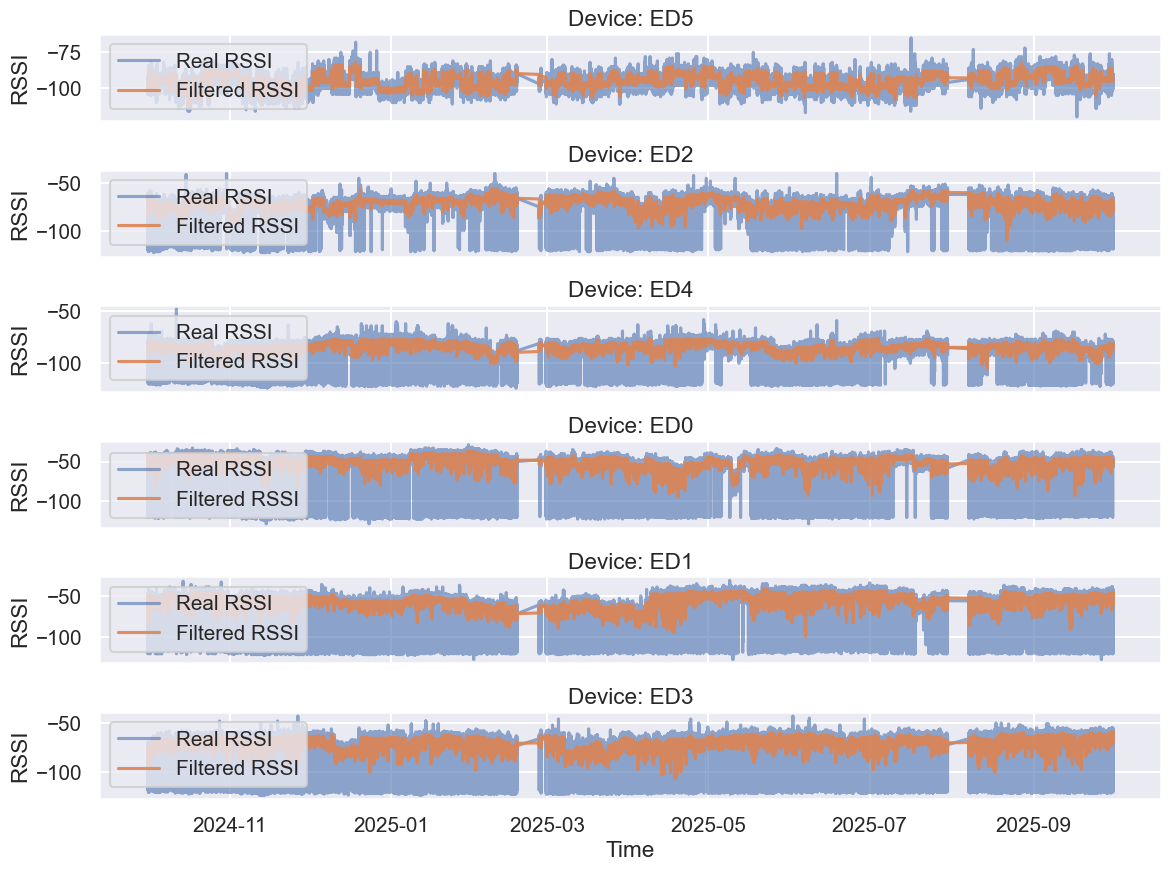

In [128]:
# Plot train data (Real vs. Filtered RSSI) for each device
device_ids = train_df['device_id'].unique()
num_devices = len(device_ids)
fig, axes = plt.subplots(nrows=num_devices, ncols=1, figsize=(12, 1.5*num_devices), sharex=True)
if num_devices == 1:
    axes = [axes]

for ax, device in zip(axes, device_ids):
    device_data = train_df[train_df['device_id'] == device].sort_values('time')
    ax.plot(device_data['time'], device_data['rssi'], label='Real RSSI', alpha=0.6)
    ax.plot(device_data['time'], device_data['filtered_rssi'], label='Filtered RSSI', alpha=0.9)
    ax.set_title(f'Device: {device}')
    ax.set_ylabel('RSSI')
    ax.legend()

plt.xlabel('Time')
plt.tight_layout()
plt.show()

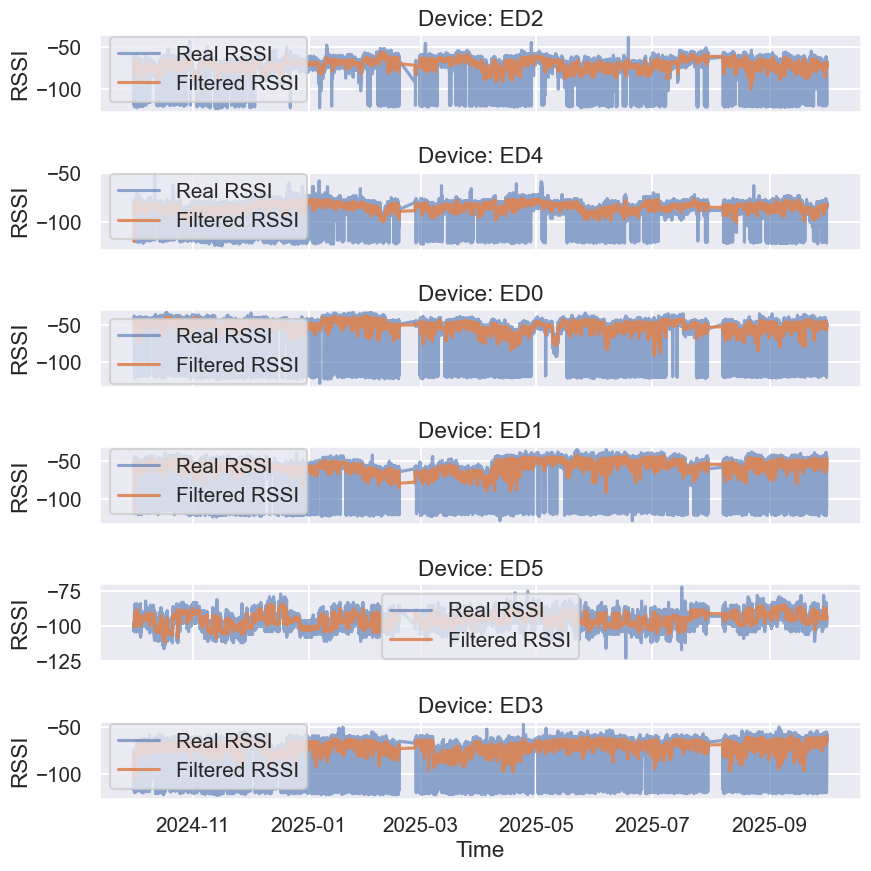

In [129]:
# Plot test data (Real vs. Filtered RSSI) for each device
device_ids_test = test_df['device_id'].unique()
num_devices_test = len(device_ids_test)
fig, axes = plt.subplots(nrows=num_devices_test, ncols=1, figsize=(9, 1.5*num_devices_test), sharex=True)
if num_devices_test == 1:
    axes = [axes]

for ax, device in zip(axes, device_ids_test):
    device_data = test_df[test_df['device_id'] == device].sort_values('time')
    ax.plot(device_data['time'], device_data['rssi'], label='Real RSSI', alpha=0.6)
    ax.plot(device_data['time'], device_data['filtered_rssi'], label='Filtered RSSI', alpha=0.9)
    ax.set_title(f'Device: {device}')
    ax.set_ylabel('RSSI')
    ax.legend()

plt.xlabel('Time')
plt.tight_layout()
plt.show()

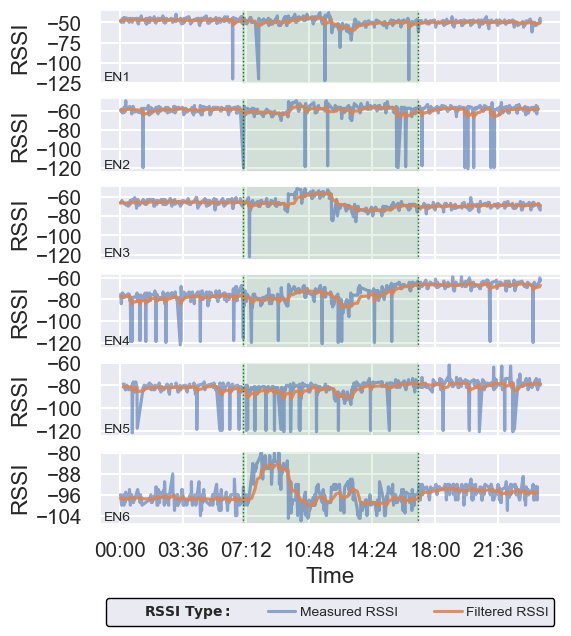

In [130]:
# Ensure 'time' column is in datetime format
train_df['time'] = pd.to_datetime(train_df['time'])

# Define the one-day segment (December 20, 2024)
segment_start = '2024-12-20 00:00:00'
segment_end   = '2024-12-20 23:59:59'
train_df_segment = train_df[
    (train_df['time'] >= segment_start) & 
    (train_df['time'] <= segment_end)
]

# Device mapping: original ID to display name
device_map = {'ED0': 'EN1', 'ED1': 'EN2', 'ED2': 'EN3', 'ED3': 'EN4', 'ED4': 'EN5', 'ED5': 'EN6'}

# Get unique device IDs in ascending order
device_ids = sorted(train_df_segment['device_id'].unique())
num_devices = len(device_ids)

# Create subplots for each device
fig, axes = plt.subplots(nrows=num_devices, ncols=1, figsize=(6, 1 * num_devices), sharex=True)
if num_devices == 1:
    axes = [axes]

# Define the highlight window (7 AM to 5 PM)
highlight_start = pd.to_datetime('2024-12-20 07:00:00')
highlight_end   = pd.to_datetime('2024-12-20 17:00:00')

for ax, device in zip(axes, device_ids):
    device_data = train_df_segment[train_df_segment['device_id'] == device].sort_values('time')
    
    # Plot real vs. filtered RSSI
    ax.plot(device_data['time'], device_data['rssi'], label='Measured RSSI', alpha=0.6)
    ax.plot(device_data['time'], device_data['filtered_rssi'], label='Filtered RSSI', alpha=0.9)
    
    # Highlight 7 AM to 5 PM with a translucent rectangle
    ax.axvspan(highlight_start, highlight_end, color='green', alpha=0.1)
    # Add dotted lines on the left and right edges of the highlight
    ax.axvline(highlight_start, color='green', linestyle=':', linewidth=1)
    ax.axvline(highlight_end,   color='green', linestyle=':', linewidth=1)
    
    # Add device name annotation (bottom left) using our mapping
    device_label = device_map.get(device, device)
    ax.text(
        0.01, 0.01, device_label,
        transform=ax.transAxes, 
        fontsize=10,
        verticalalignment='bottom', 
        horizontalalignment='left'
    )
    
    ax.set_ylabel('RSSI')
    
    # Set the common x-axis to have 10 ticks
    ax.xaxis.set_major_locator(ticker.MaxNLocator(10))
    # Optional: format x-axis labels for datetimes
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    
    # Set y-axis tick locator to force 4 ticks for all subplots
    ax.yaxis.set_major_locator(ticker.MaxNLocator(4))
    
    # Set all subplot borders (spines) to width 2
    for spine in ax.spines.values(): spine.set_linewidth(2)

# Finalize subplot layout and compute positions
plt.tight_layout(h_pad=0.01)  # Reduced gap between plots
fig.canvas.draw()

# Get left & width of the first subplot in figure coords
pos = axes[0].get_position()

# Shared legend below the figure, spanning exactly the subplot width
dummy_handle = mpatches.Patch(color='none', label=r'$\mathbf{RSSI\ Type:}$')
handles, labels = axes[0].get_legend_handles_labels()
handles = [dummy_handle] + handles
labels  = [r'$\mathbf{RSSI\ Type:}$'] + labels

legend = fig.legend(
    handles, labels,
    loc='lower left',
    bbox_to_anchor=(pos.x0, -0.08, pos.width, 0.05),
    mode='expand',
    ncol=3,
    frameon=True,
    fontsize=10,
    labelspacing=0.1,
    columnspacing=0.5,
    handletextpad=0.3
)
legend.get_frame().set_linewidth(1)
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_alpha(1)

plt.xlabel('Time')

# Save the figure at high resolution without cropping
plt.savefig(
    '../all_data_files/Localization/Real_vs_FilteredRSSI_over_shortTime.png', dpi=2000, bbox_inches='tight', pad_inches=0.01)
plt.show()

# Log-Distance Path Loss & Shadowing Modeling

We adopt the following two models:

1. **LDPLM-MW (Structural Model):**

$$
PL(d) = PL(d_0) + 10\,n\,\log_{10}\!\left(\frac{d}{d_0}\right) + \sum_{i=1}^{2} W_i\,L_i + \epsilon,
$$

where:
- $PL(d_0)$ is the reference path loss,
- $n$ is the path loss exponent,
- $d$ is the distance,
- $W_1 = c_{walls}$ and $W_2 = w_{walls}$ are the counts of two wall types,
- $L_1 = L_c$ and $L_2 = L_w$ are their corresponding attenuation factors, and
- $\epsilon$ captures random shadowing effects.

2. **LDPLM-MW-EP (Extended Model with Environmental Parameters):**

$$
PL(d) = PL(d_0) + 10\,n\,\log_{10}\!\left(\frac{d}{d_0}\right) + 20\,\log_{10}(f) + \sum_{i=1}^{2} W_i\,L_i + \sum_{j=1}^{5} \theta_j\,E_j + k_{snr}\,snr + \epsilon,
$$

where, in addition to the parameters above:
- $f$ is the frequency,
- $20\,\log_{10}(f)$ accounts for frequency-dependent loss,
- $\{E_j\}_{j=1}^{5}$ are five environmental variables (e.g., CO$_2$, humidity, PM2.5, pressure, temperature) with corresponding coefficients $\{\theta_j\}$,
- $snr$ is the signal-to-noise ratio with coefficient $k_{snr}$.

These models form the basis of our analysis and are implemented as follows.


In [131]:
# Feature Extraction & Model Function Definitions
features = ['distance', 'frequency', 'c_walls', 'w_walls', 'co2', 
            'humidity', 'pm25', 'pressure', 'temperature', 'snr']
X_train = np.column_stack([train_df[feat].values for feat in features])
X_test  = np.column_stack([test_df[feat].values for feat in features])

# Targets: raw and filtered exp_pl
y_train_raw  = train_df['exp_pl'].values
y_test_raw   = test_df['exp_pl'].values
y_train_filt = train_df['exp_pl_filtered'].values
y_test_filt  = test_df['exp_pl_filtered'].values

# LDPLM-MW: using distance, c_walls, w_walls (indices 0,2,3)
def log_distance_path_loss_separate_walls(x, PL_d0, n, L_c, L_w):
    d, c_walls, w_walls = x
    d0 = 1
    return PL_d0 + 10 * n * np.log10(d/d0) + c_walls * L_c + w_walls * L_w

# LDPLM-MW-EP: using all 10 features
def log_distance_path_loss_with_env_params(x, PL_d0, n, L_c, L_w, a_co2, a_hum, a_pm25, a_pres, a_temp, k_snr):
    d, freq, c_walls, w_walls, co2, hum, pm25, pres, temp, snr = x
    d0 = 1
    return (PL_d0 + 10 * n * np.log10(d/d0) + 20*np.log10(freq) +
            c_walls * L_c + w_walls * L_w +
            a_co2 * co2 + a_hum * hum + a_pm25 * pm25 +
            a_pres * pres + a_temp * temp + snr * k_snr)

idx_mw = [0, 2, 3]
idx_ep = list(range(10))

### Model Fitting & Evaluation (Raw and Filtered)

In [132]:
# Initial guesses
initial_guess_mw = [30, 2, 5, 3]
initial_guess_ep = [30, 2, 5, 3, 0.01, 0.01, 0.01, 0.01, 0.01, 1]

# --- Fit on Raw exp_pl ---
popt_mw_raw, _ = curve_fit(
    log_distance_path_loss_separate_walls,
    X_train[:, idx_mw].T, y_train_raw, p0=initial_guess_mw, maxfev=100000)
popt_ep_raw, _ = curve_fit(
    log_distance_path_loss_with_env_params,
    X_train[:, idx_ep].T, y_train_raw, p0=initial_guess_ep, maxfev=100000)

# --- Fit on Filtered exp_pl ---
popt_mw_filt, _ = curve_fit(
    log_distance_path_loss_separate_walls,
    X_train[:, idx_mw].T, y_train_filt, p0=initial_guess_mw, maxfev=100000)
popt_ep_filt, _ = curve_fit(
    log_distance_path_loss_with_env_params,
    X_train[:, idx_ep].T, y_train_filt, p0=initial_guess_ep, maxfev=100000)

# --- Predictions ---
# Raw models
y_pred_mw_raw   = log_distance_path_loss_separate_walls(X_test[:, idx_mw].T, *popt_mw_raw)
y_pred_ep_raw   = log_distance_path_loss_with_env_params(X_test[:, idx_ep].T, *popt_ep_raw)
y_train_pred_mw_raw = log_distance_path_loss_separate_walls(X_train[:, idx_mw].T, *popt_mw_raw)
y_train_pred_ep_raw = log_distance_path_loss_with_env_params(X_train[:, idx_ep].T, *popt_ep_raw)
# Filtered models
y_pred_mw_filt  = log_distance_path_loss_separate_walls(X_test[:, idx_mw].T, *popt_mw_filt)
y_pred_ep_filt  = log_distance_path_loss_with_env_params(X_test[:, idx_ep].T, *popt_ep_filt)
y_train_pred_mw_filt = log_distance_path_loss_separate_walls(X_train[:, idx_mw].T, *popt_mw_filt)
y_train_pred_ep_filt = log_distance_path_loss_with_env_params(X_train[:, idx_ep].T, *popt_ep_filt)

# --- Shadowing (train) & Metrics ---
shadowing_mw_raw  = y_train_raw - y_train_pred_mw_raw
sigma_mw_raw      = np.std(shadowing_mw_raw)
shadowing_ep_raw  = y_train_raw - y_train_pred_ep_raw
sigma_ep_raw      = np.std(shadowing_ep_raw)
shadowing_mw_filt = y_train_filt - y_train_pred_mw_filt
sigma_mw_filt     = np.std(shadowing_mw_filt)
shadowing_ep_filt = y_train_filt - y_train_pred_ep_filt
sigma_ep_filt     = np.std(shadowing_ep_filt)

# Test metrics
rmse_mw_raw_test  = np.sqrt(mean_squared_error(y_test_raw, y_pred_mw_raw))
r2_mw_raw_test    = r2_score(y_test_raw, y_pred_mw_raw)
rmse_ep_raw_test  = np.sqrt(mean_squared_error(y_test_raw, y_pred_ep_raw))
r2_ep_raw_test    = r2_score(y_test_raw, y_pred_ep_raw)
rmse_mw_filt_test = np.sqrt(mean_squared_error(y_test_filt, y_pred_mw_filt))
r2_mw_filt_test   = r2_score(y_test_filt, y_pred_mw_filt)
rmse_ep_filt_test = np.sqrt(mean_squared_error(y_test_filt, y_pred_ep_filt))
r2_ep_filt_test   = r2_score(y_test_filt, y_pred_ep_filt)

# Train metrics
rmse_mw_raw_train  = np.sqrt(mean_squared_error(y_train_raw, y_train_pred_mw_raw))
r2_mw_raw_train    = r2_score(y_train_raw, y_train_pred_mw_raw)
rmse_ep_raw_train  = np.sqrt(mean_squared_error(y_train_raw, y_train_pred_ep_raw))
r2_ep_raw_train    = r2_score(y_train_raw, y_train_pred_ep_raw)
rmse_mw_filt_train = np.sqrt(mean_squared_error(y_train_filt, y_train_pred_mw_filt))
r2_mw_filt_train   = r2_score(y_train_filt, y_train_pred_mw_filt)
rmse_ep_filt_train = np.sqrt(mean_squared_error(y_train_filt, y_train_pred_ep_filt))
r2_ep_filt_train   = r2_score(y_train_filt, y_train_pred_ep_filt)

### Parameter & Metrics Comparison

In [133]:
# Parameters from curve fitting
params_mw_raw  = {'PL(d0)': popt_mw_raw[0], 'n': popt_mw_raw[1], 'L_c': popt_mw_raw[2], 'L_w': popt_mw_raw[3]}
params_ep_raw  = {'PL(d0)': popt_ep_raw[0], 'n': popt_ep_raw[1], 'L_c': popt_ep_raw[2], 'L_w': popt_ep_raw[3],
                  'a_co2': popt_ep_raw[4], 'a_hum': popt_ep_raw[5], 'a_pm25': popt_ep_raw[6],
                  'a_pres': popt_ep_raw[7], 'a_temp': popt_ep_raw[8], 'k_snr': popt_ep_raw[9]}
params_mw_filt = {'PL(d0)': popt_mw_filt[0], 'n': popt_mw_filt[1], 'L_c': popt_mw_filt[2], 'L_w': popt_mw_filt[3]}
params_ep_filt = {'PL(d0)': popt_ep_filt[0], 'n': popt_ep_filt[1], 'L_c': popt_ep_filt[2], 'L_w': popt_ep_filt[3],
                  'a_co2': popt_ep_filt[4], 'a_hum': popt_ep_filt[5], 'a_pm25': popt_ep_filt[6],
                  'a_pres': popt_ep_filt[7], 'a_temp': popt_ep_filt[8], 'k_snr': popt_ep_filt[9]}

# Build table of parameters for all 4 models
shared_params = ['PL(d0)', 'n', 'L_c', 'L_w']
unique_params = ['a_co2', 'a_hum', 'a_pm25', 'a_pres', 'a_temp', 'k_snr']
parameter_list = shared_params + unique_params

ldplm_mw_raw_vals  = [params_mw_raw.get(p, '-') for p in parameter_list]
ldplm_ep_raw_vals  = [params_ep_raw.get(p, '-') for p in parameter_list]
ldplm_mw_filt_vals = [params_mw_filt.get(p, '-') for p in parameter_list]
ldplm_ep_filt_vals = [params_ep_filt.get(p, '-') for p in parameter_list]

params_comp_df = pd.DataFrame({
    'MWM': ldplm_mw_raw_vals,
    'MWM-KF': ldplm_mw_filt_vals,
    'MWM-EP': ldplm_ep_raw_vals,
    'MWM-EP-KF': ldplm_ep_filt_vals
}, index=parameter_list)

# Build Metrics DataFrame
metrics = ['RMSE (Train)', 'RMSE (Test)', 'R2 (Train)', 'R2 (Test)', 'σ (dB)']
metrics_values = {
    'MWM': [rmse_mw_raw_train, rmse_mw_raw_test, r2_mw_raw_train, r2_mw_raw_test, sigma_mw_raw],
    'MWM-KF': [rmse_mw_filt_train, rmse_mw_filt_test, r2_mw_filt_train, r2_mw_filt_test, sigma_mw_filt],
    'MWM-EP': [rmse_ep_raw_train, rmse_ep_raw_test, r2_ep_raw_train, r2_ep_raw_test, sigma_ep_raw],
    'MWM-EP-KF': [rmse_ep_filt_train, rmse_ep_filt_test, r2_ep_filt_train, r2_ep_filt_test, sigma_ep_filt]
}
metrics_df = pd.DataFrame(metrics_values, index=metrics)

#### Performance Metrics

In [134]:
# Output the two tables
print("\n=== Table of Parameters to be Compared ===\n")
display(params_comp_df)

print("\n=== Performance Metrics ===\n")
display(metrics_df)


=== Table of Parameters to be Compared ===



,MWM,MWM-KF,MWM-EP,MWM-EP-KF
PL(d0),25.099545,25.101408,-3.450445,-25.163439
n,4.355895,4.355693,4.045316,4.309558
L_c,7.082106,7.082635,6.234593,7.019231
L_w,1.483551,1.483835,1.727553,1.461152
a_co2,-,-,-0.002279,-0.004320
a_hum,-,-,-0.082463,-0.097746
a_pm25,-,-,-0.044108,-0.065001
a_pres,-,-,0.002389,0.015014
a_temp,-,-,-0.102270,-0.127378
k_snr,-,-,-2.085111,-0.372486



=== Performance Metrics ===



,MWM,MWM-KF,MWM-EP,MWM-EP-KF
RMSE (Train),10.992909,5.701683,8.119557,5.471999
RMSE (Test),10.945920,5.569695,8.085167,5.354926
R2 (Train),0.658890,0.877754,0.813905,0.887405
R2 (Test),0.661646,0.883076,0.815395,0.891919
σ (dB),10.992909,5.701683,8.119557,5.471999


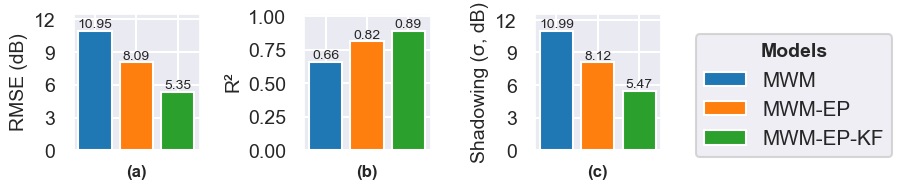

In [135]:
# Subset of models we want to compare
model_subset = ['MWM', 'MWM-EP', 'MWM-EP-KF']

# Extract the relevant test metrics from your metrics_df
rmse_test_values = metrics_df.loc['RMSE (Test)', model_subset]
r2_test_values   = metrics_df.loc['R2 (Test)', model_subset]
sigma_values     = metrics_df.loc['σ (dB)', model_subset]  # Shadowing

# Create figure and subplots
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(7, 2.2))

# Define a color scheme for the three bars
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

# ----------------------
# (a) RMSE(Test)
# ----------------------
bars_a = axs[0].bar(model_subset, rmse_test_values, color=colors)
axs[0].set_ylabel('RMSE (dB)', fontsize=14)
axs[0].tick_params(axis='x', bottom=False, labelbottom=False)
axs[0].tick_params(axis='y', labelsize=14)
axs[0].text(0.5, -0.1, '(a)', transform=axs[0].transAxes,
            fontsize=12, fontweight='bold', ha='center', va='top')
# Label each bar in subplot (a) for the legend
for bar, label in zip(bars_a, model_subset):
    bar.set_label(label)

# ----------------------
# (b) R²(Test)
# ----------------------
axs[1].bar(model_subset, r2_test_values, color=colors)
axs[1].set_ylabel('R²', fontsize=14)
axs[1].tick_params(axis='x', bottom=False, labelbottom=False)
axs[1].tick_params(axis='y', labelsize=14)
axs[1].text(0.5, -0.1, '(b)', transform=axs[1].transAxes,
            fontsize=12, fontweight='bold', ha='center', va='top')

# ----------------------
# (c) Shadowing (σ dB)
# ----------------------
axs[2].bar(model_subset, sigma_values, color=colors)
axs[2].set_ylabel('Shadowing (σ, dB)', fontsize=14)
axs[2].tick_params(axis='x', bottom=False, labelbottom=False)
axs[2].tick_params(axis='y', labelsize=14)
axs[2].text(0.5, -0.1, '(c)', transform=axs[2].transAxes,
            fontsize=12, fontweight='bold', ha='center', va='top')

# Set each subplot's y-axis to have about 5 ticks using MaxNLocator
for ax in axs:
    ax.yaxis.set_major_locator(MaxNLocator(nbins=5))

# Set border (spine) width for both subplots
for ax in axs:
    [s.set_linewidth(2) for s in ax.spines.values()]
    # Annotate bar values safely
    for bar in ax.patches:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    (bar.get_x() + bar.get_width() / 2, height),
                    ha='center', va='bottom', fontsize=10,
                    clip_on=True)  # <- ensures text stays inside the axes

# Add headroom for bar labels
for ax in axs:
    y_max = max([bar.get_height() for bar in ax.patches])
    ax.set_ylim(top=y_max * 1.15)  # 15% headroom
    
# Create one combined legend on the right-hand side with a bold title
handles, labels = axs[0].get_legend_handles_labels()
legend = fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1,
                    title='Models')
legend.get_title().set_fontsize(14)
legend.get_title().set_fontweight('bold')

# Adjust layout to account for the legend on the right and reduce the white gap at the bottom
plt.subplots_adjust(right=0.85, bottom=0.15)
plt.tight_layout()

# Save the figure at high resolution
plt.savefig('../all_data_files/Localization/rmse_r2_comparison.png', dpi=2000, bbox_inches='tight')
plt.show()

### Combined Plots (Raw & Filtered) and Residual Distribution Table

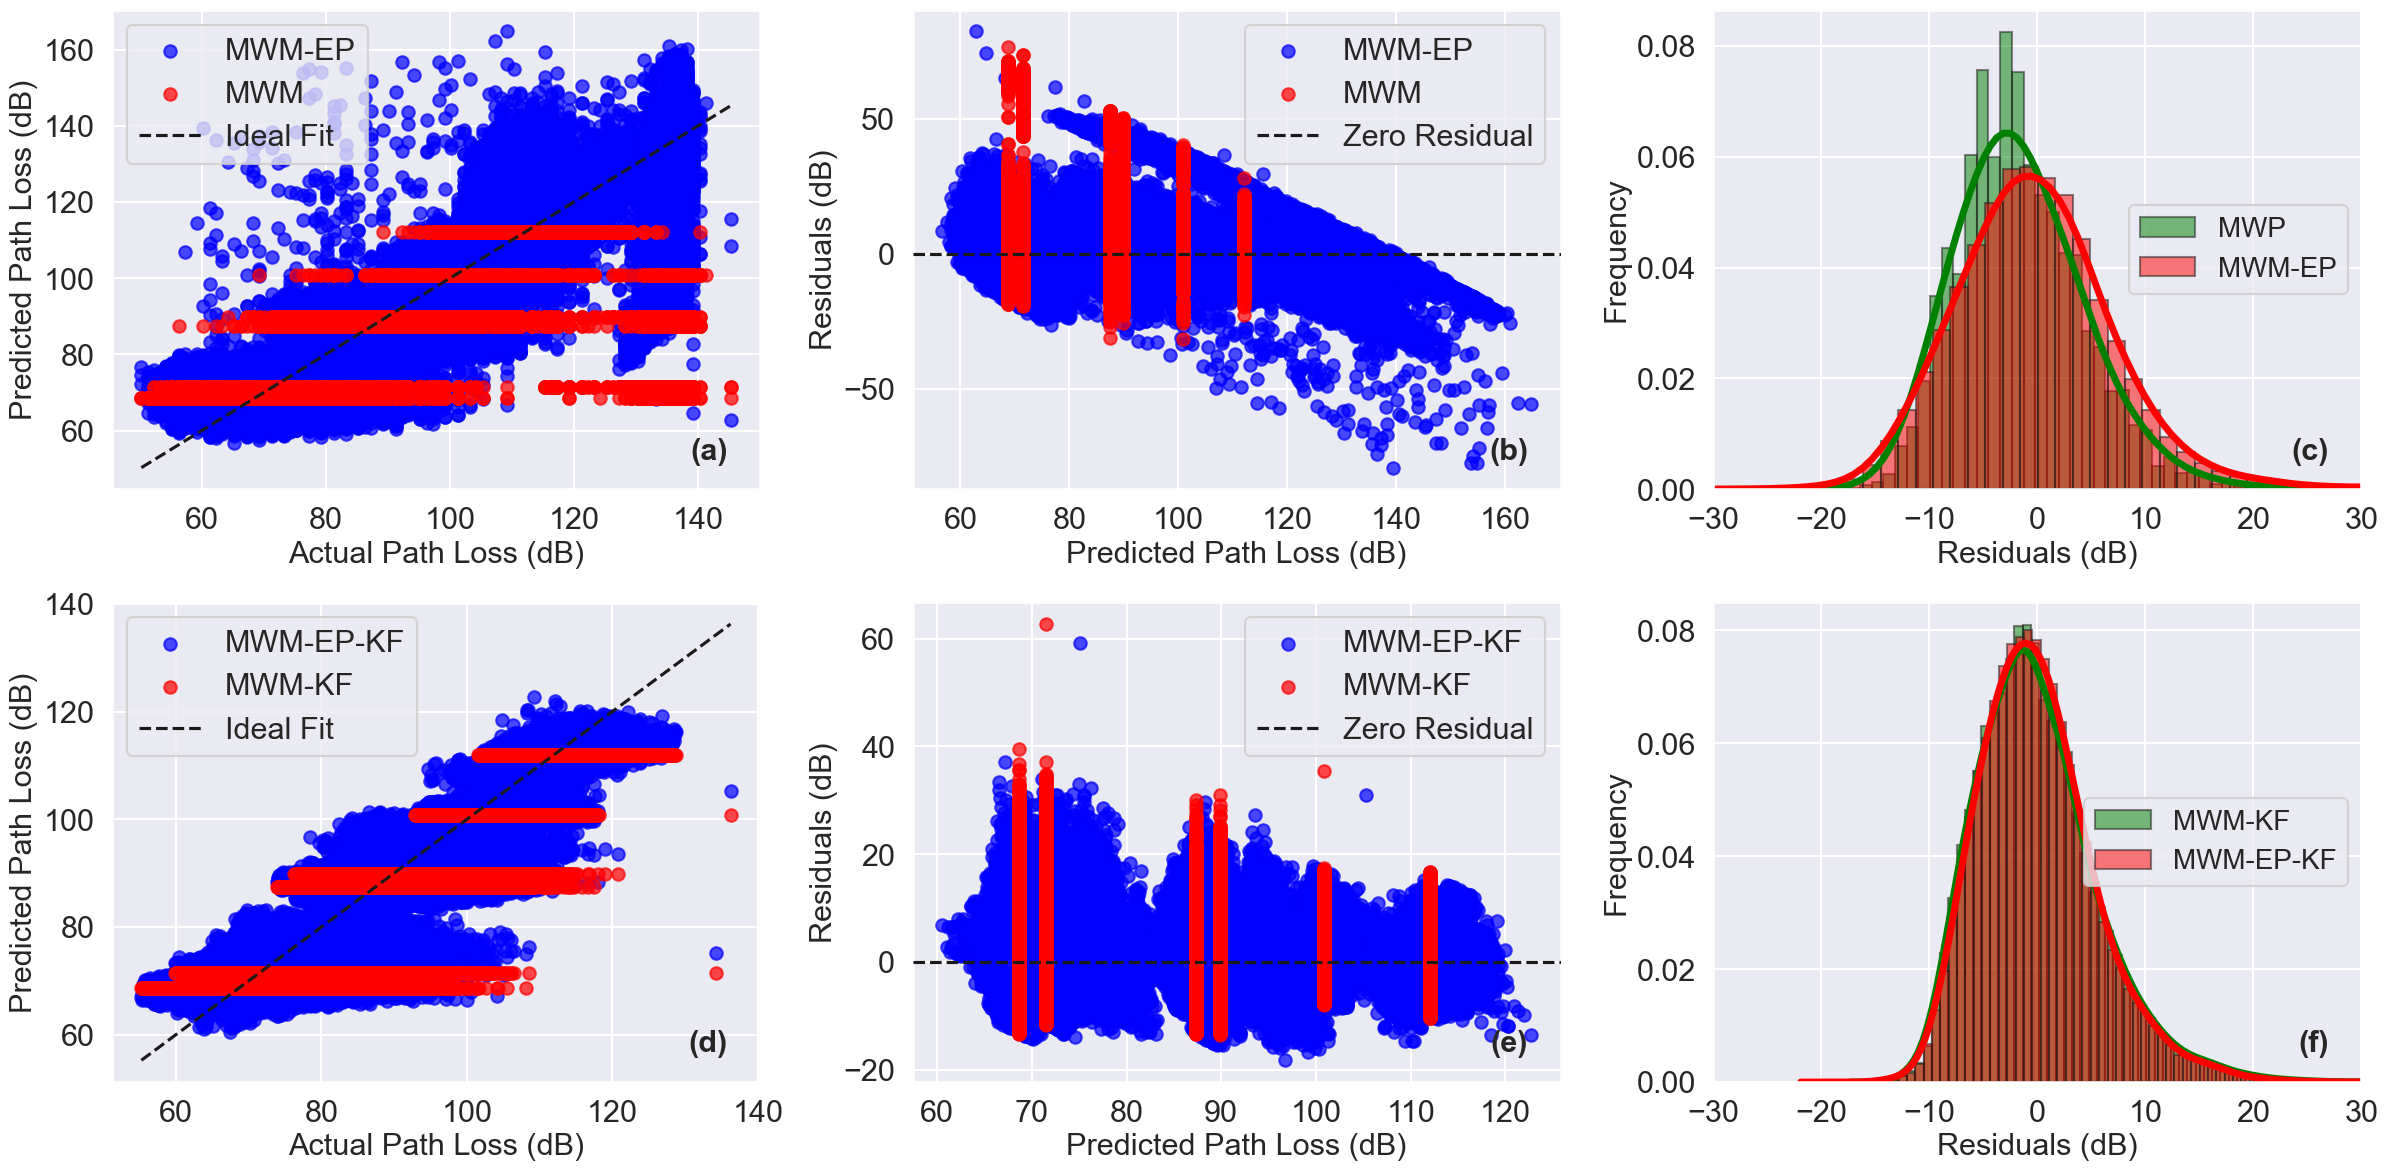


Residual Distribution Values:


,Mean (dB),Skewness
MWM,-0.023880,3.679844
MWM-KF,-0.022809,0.815063
MWM-EP,-0.015155,1.081909
MWM-EP-KF,-0.020706,0.732202


In [136]:
# Compute test residuals for raw and filtered models
residuals_mw_test = y_test_raw - y_pred_mw_raw
residuals_ep_test = y_test_raw - y_pred_ep_raw
residuals_mw_test_filt = y_test_filt - y_pred_mw_filt
residuals_ep_test_filt = y_test_filt - y_pred_ep_filt

# Define plotting targets/predictions (raw & filtered)
PL_test_mw = y_test_raw        # Raw target for MW & EP (identical)
PL_test_ep = y_test_raw
PL_pred_mw = y_pred_mw_raw     # Raw predictions
PL_pred_ep = y_pred_ep_raw

PL_test_mw_filt = y_test_filt  # Filtered targets for MW & EP (identical)
PL_test_ep_filt = y_test_filt
PL_pred_mw_filt = y_pred_mw_filt  # Filtered predictions
PL_pred_ep_filt = y_pred_ep_filt

# Define ideal fit line boundaries
min_PL = min(PL_test_ep.min(), PL_test_mw.min())
max_PL = max(PL_test_ep.max(), PL_test_mw.max())
min_PL_filt = min(PL_test_ep_filt.min(), PL_test_mw_filt.min())
max_PL_filt = max(PL_test_ep_filt.max(), PL_test_mw_filt.max())

# Create a figure with 2 rows x 3 columns (Row 1: Raw, Row 2: Filtered)
fig, axes = plt.subplots(2, 3, figsize=(24, 12))

# -------------------- Row 1: Raw Models --------------------
# (a) Actual vs Predicted Path Loss
ax = axes[0, 0]
ax.scatter(PL_test_ep, PL_pred_ep, alpha=0.7, label='MWM-EP', color='blue', zorder=2)
ax.scatter(PL_test_mw, PL_pred_mw, alpha=0.7, label='MWM', color='red', zorder=3)
ax.plot([min_PL, max_PL], [min_PL, max_PL], 'k--', label='Ideal Fit', zorder=4)
ax.set_xlabel('Actual Path Loss (dB)', fontsize=22)
ax.set_ylabel('Predicted Path Loss (dB)', fontsize=22)
ax.legend(fontsize=22, loc='upper left')
ax.grid(True)
ax.tick_params(axis='both', which='major', labelsize=22)
ax.text(0.95, 0.05, '(a)', transform=ax.transAxes, fontsize=22, fontweight='bold', va='bottom', ha='right')

# (b) Residuals vs Predicted Path Loss
ax = axes[0, 1]
ax.scatter(PL_pred_ep, residuals_ep_test, alpha=0.7, label='MWM-EP', color='blue', zorder=2)
ax.scatter(PL_pred_mw, residuals_mw_test, alpha=0.7, label='MWM', color='red', zorder=3)
ax.axhline(0, color='k', linestyle='--', label='Zero Residual', zorder=4)
ax.set_xlabel('Predicted Path Loss (dB)', fontsize=22)
ax.set_ylabel('Residuals (dB)', fontsize=22)
ax.legend(fontsize=22, loc='upper right')
ax.grid(True)
ax.tick_params(axis='both', which='major', labelsize=22)
ax.text(0.95, 0.05, '(b)', transform=ax.transAxes, fontsize=22, fontweight='bold', va='bottom', ha='right')

# (c) Histogram & KDE of Residuals
ax = axes[0, 2]
ax.hist(residuals_mw_test, bins=100, alpha=0.5, label='MWP', color='green', edgecolor='k', density=True)
ax.hist(residuals_ep_test, bins=100, alpha=0.5, label='MWM-EP', color='red', edgecolor='k', density=True)
sns.kdeplot(residuals_mw_test, color='green', bw_adjust=3, ax=ax, linewidth=5)
sns.kdeplot(residuals_ep_test, color='red', bw_adjust=3, ax=ax, linewidth=5)
ax.set_xlabel('Residuals (dB)', fontsize=22)
ax.set_ylabel('Frequency', fontsize=22)
ax.set_xlim(-30, 30)
ax.legend(fontsize=20, loc='center right')
ax.grid(True)
ax.tick_params(axis='both', which='major', labelsize=22)
ax.text(0.95, 0.05, '(c)', transform=ax.transAxes, fontsize=22, fontweight='bold', va='bottom', ha='right')

# -------------------- Row 2: Filtered Models --------------------
# (d) Actual vs Predicted Path Loss (Filtered)
ax = axes[1, 0]
ax.scatter(PL_test_ep_filt, PL_pred_ep_filt, alpha=0.7, label='MWM-EP-KF', color='blue', zorder=2)
ax.scatter(PL_test_mw_filt, PL_pred_mw_filt, alpha=0.7, label='MWM-KF', color='red', zorder=3)
ax.plot([min_PL_filt, max_PL_filt], [min_PL_filt, max_PL_filt], 'k--', label='Ideal Fit', zorder=4)
ax.set_xlabel('Actual Path Loss (dB)', fontsize=22)
ax.set_ylabel('Predicted Path Loss (dB)', fontsize=22)
ax.legend(fontsize=22, loc='upper left')
ax.grid(True)
ax.tick_params(axis='both', which='major', labelsize=22)
ax.text(0.95, 0.05, '(d)', transform=ax.transAxes, fontsize=22, fontweight='bold', va='bottom', ha='right')

# (e) Residuals vs Predicted Path Loss (Filtered)
ax = axes[1, 1]
ax.scatter(PL_pred_ep_filt, residuals_ep_test_filt, alpha=0.7, label='MWM-EP-KF', color='blue', zorder=2)
ax.scatter(PL_pred_mw_filt, residuals_mw_test_filt, alpha=0.7, label='MWM-KF', color='red', zorder=3)
ax.axhline(0, color='k', linestyle='--', label='Zero Residual', zorder=4)
ax.set_xlabel('Predicted Path Loss (dB)', fontsize=22)
ax.set_ylabel('Residuals (dB)', fontsize=22)
ax.legend(fontsize=22, loc='upper right')
ax.grid(True)
ax.tick_params(axis='both', which='major', labelsize=22)
ax.text(0.95, 0.05, '(e)', transform=ax.transAxes, fontsize=22, fontweight='bold', va='bottom', ha='right')

# (f) Histogram & KDE of Residuals (Filtered)
ax = axes[1, 2]
ax.hist(residuals_mw_test_filt, bins=100, alpha=0.5, label='MWM-KF', color='green', edgecolor='k', density=True)
ax.hist(residuals_ep_test_filt, bins=100, alpha=0.5, label='MWM-EP-KF', color='red', edgecolor='k', density=True)
sns.kdeplot(residuals_mw_test_filt, color='green', bw_adjust=3, ax=ax, linewidth=5)
sns.kdeplot(residuals_ep_test_filt, color='red', bw_adjust=3, ax=ax, linewidth=5)
ax.set_xlabel('Residuals (dB)', fontsize=22)
ax.set_ylabel('Frequency', fontsize=22)
ax.set_xlim(-30, 30)
ax.legend(fontsize=20, loc='center right')
ax.grid(True)
ax.tick_params(axis='both', which='major', labelsize=22)
ax.text(0.95, 0.05, '(f)', transform=ax.transAxes, fontsize=22, fontweight='bold', va='bottom', ha='right')

plt.tight_layout()
plt.savefig('../all_data_files/All_Plots_as_Subplots_Kalman.png', dpi=1000)
plt.show()

# -------------------- Residual Distribution Table (Test Data) --------------------
resid_mean_mw      = round(np.mean(residuals_mw_test), 6)
resid_skew_mw      = round(pd.Series(residuals_mw_test).skew(), 6)
resid_mean_ep      = round(np.mean(residuals_ep_test), 6)
resid_skew_ep      = round(pd.Series(residuals_ep_test).skew(), 6)
resid_mean_mw_filt = round(np.mean(residuals_mw_test_filt), 6)
resid_skew_mw_filt = round(pd.Series(residuals_mw_test_filt).skew(), 6)
resid_mean_ep_filt = round(np.mean(residuals_ep_test_filt), 6)
resid_skew_ep_filt = round(pd.Series(residuals_ep_test_filt).skew(), 6)

resid_df = pd.DataFrame({
    'Mean (dB)': [resid_mean_mw, resid_mean_mw_filt, resid_mean_ep, resid_mean_ep_filt],
    'Skewness': [resid_skew_mw, resid_skew_mw_filt, resid_skew_ep, resid_skew_ep_filt]
}, index=['MWM', 'MWM-KF', 'MWM-EP', 'MWM-EP-KF'])

print("\nResidual Distribution Values:")
display(resid_df)

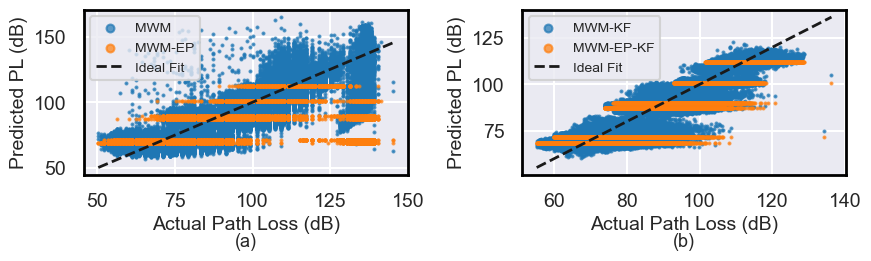

In [137]:
# Create a figure with 1 row x 2 columns
fig, axs = plt.subplots(1, 2, figsize=(9, 3.5))

# ----------------------
# (a) Raw Models 
# ----------------------
ax_left = axs[0]
ax_left.scatter(PL_test_ep, PL_pred_ep, s=2, alpha=0.7, label='MWM', color='#1f77b4', zorder=2)
ax_left.scatter(PL_test_mw, PL_pred_mw, s=2, alpha=0.7, label='MWM-EP', color='#ff7f0e', zorder=3)
ax_left.plot([min_PL, max_PL], [min_PL, max_PL], 'k--', linewidth=2, label='Ideal Fit', zorder=4)
ax_left.set_xlabel('Actual Path Loss (dB)', fontsize=14)
ax_left.set_ylabel('Predicted PL (dB)', fontsize=14)
ax_left.grid(True)
ax_left.tick_params(axis='both', which='major', labelsize=14)
ax_left.text(0.5, -0.35, '(a)', transform=ax_left.transAxes,
             fontsize=13, ha='center', va='top')
# Place the legend inside the left subplot (top left)
ax_left.legend(loc='upper left', fontsize=10, markerscale=4)

# ----------------------
# (b) Filtered Models 
# ----------------------
ax_right = axs[1]
ax_right.scatter(PL_test_ep_filt, PL_pred_ep_filt, s=2, alpha=0.7, label='MWM-KF', color='#1f77b4', zorder=2)
ax_right.scatter(PL_test_mw_filt, PL_pred_mw_filt, s=2, alpha=0.7, label='MWM-EP-KF', color='#ff7f0e', zorder=3)
ax_right.plot([min_PL_filt, max_PL_filt], [min_PL_filt, max_PL_filt], 'k--', linewidth=2, label='Ideal Fit', zorder=4)
ax_right.set_xlabel('Actual Path Loss (dB)', fontsize=14)
ax_right.set_ylabel('Predicted PL (dB)', fontsize=14)
ax_right.grid(True)
ax_right.tick_params(axis='both', which='major', labelsize=14)
ax_right.text(0.5, -0.35, '(b)', transform=ax_right.transAxes,
              fontsize=13, ha='center', va='top')
# Place the legend inside the right subplot (top left)
ax_right.legend(loc='upper left', fontsize=10, markerscale=4)


# Set all subplot borders (spines) to width 2
for ax in axs: 
     for s in ax.spines.values():
        s.set_linewidth(2)
        s.set_color('black')

# Final layout & save
plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.savefig('../all_data_files/Localization/Kalman_vs_Raw_Residuals.png', dpi=2000, bbox_inches='tight')
plt.show()

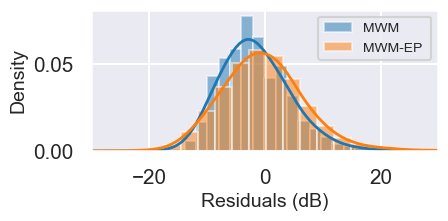

In [138]:
plt.figure(figsize=(5, 2.5))
# Plot histograms for residuals with density normalization
plt.hist(residuals_mw_test, bins=55, alpha=0.5, label='MWM', color='#1f77b4', density=True)
plt.hist(residuals_ep_test, bins=55, alpha=0.5, label='MWM-EP ', color='#ff7f0e', density=True)
# Plot KDE curves for both residual distributions
sns.kdeplot(residuals_mw_test, color='#1f77b4', bw_adjust=3, linewidth=2)
sns.kdeplot(residuals_ep_test, color='#ff7f0e', bw_adjust=3, linewidth=2)
# Set labels, title, and x-axis limits
plt.xlabel('Residuals (dB)', fontsize=14)
plt.ylabel('Density', fontsize=14)
#plt.title('Residual Distribution (Raw Models)', fontsize=18)
plt.xlim(-30, 30)
plt.legend(fontsize=10, loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.savefig('../all_data_files/Localization/residuals.png', dpi=1000, bbox_inches='tight')
plt.show()

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: center;">
 Distance Estimation for Localization
</p>

### Distance Estimation: The Base Equations

To estimate the distance $d$, we invert our main path loss models. This provides a direct means to compute the distance from the observed path loss values. The derivations are kept succinct to maintain clarity.

**Model A (LDPLM-MW):**

<div style="font-size: 150%;">
$$
d = 10^{\frac{PL - PL(d_0) - \left(W_c L_c + W_w L_w\right)}{10\,n}},
$$

</div>

**Model B (LDPLM-MW-EP):**

<div style="font-size: 150%;">

$$
d = 10^{\frac{PL - PL(d_0) - 20\,\log_{10}(f) - \left(W_c L_c + W_w L_w\right) - \sum_{j=1}^{5} \theta_j\,E_j - k_{snr}\,snr}{10\,n}}.
$$
</div>




These inverted equations allow us to compute the distance from the measured path loss while accounting for both structural losses (from walls) and environmental factors.


In [139]:
# ----------------------------
# Define Distance Inversion Functions for distance estimation
# ----------------------------
def estimate_distance_modelA(PL, PL_d0, n, L_c, L_w, W_c, W_w):
    # MWM: Model A
    # PL = PL(d0) + 10*n*log10(d) + (W_c*L_c + W_w*L_w) + ε
    return 10 ** ((PL - PL_d0 - (W_c * L_c + W_w * L_w)) / (10 * n))

def estimate_distance_modelB(PL, PL_d0, n, L_c, L_w, f, theta_E, E_matrix, k_snr, SNR, W_c, W_w):
    # MWM-EP: Model B
    # PL = PL(d0) + 10*n*log10(d) + 20*log10(f) + (W_c*L_c + W_w*L_w)
    #      + (θ1*E1 + ... + θ5*E5) + k_SNR*SNR + ε
    env_term = np.dot(theta_E, E_matrix)  # E_matrix shape: (5, number_of_samples)
    return 10 ** ((PL - PL_d0 - 20*np.log10(f) - (W_c * L_c + W_w * L_w) - env_term - k_snr * SNR) / (10 * n))

# ------------------------------------------------------------
# Prepare Environmental Data; particularly for Model B
# ------------------------------------------------------------
E_matrix_test = np.array([
    test_df['co2'].values,
    test_df['humidity'].values,
    test_df['pm25'].values,
    test_df['pressure'].values,
    test_df['temperature'].values
])
f_test   = test_df['frequency'].values
W_c_test = test_df['c_walls'].values
W_w_test = test_df['w_walls'].values
SNR_test = test_df['snr'].values

# ----------------------------
# Compute Distance Estimates (using full PL)
# ----------------------------
# Model A (MWM)
d_A_raw = estimate_distance_modelA(
    PL = test_df['exp_pl'].values,
    PL_d0 = popt_mw_raw[0],
    n = popt_mw_raw[1],
    L_c = popt_mw_raw[2],
    L_w = popt_mw_raw[3],
    W_c = W_c_test,
    W_w = W_w_test
)
d_A_filt = estimate_distance_modelA(
    PL = test_df['exp_pl_filtered'].values,
    PL_d0 = popt_mw_filt[0],
    n = popt_mw_filt[1],
    L_c = popt_mw_filt[2],
    L_w = popt_mw_filt[3],
    W_c = W_c_test,
    W_w = W_w_test
)

# Model B (MWM-EP)
theta_E_raw  = popt_ep_raw[4:9]
theta_E_filt = popt_ep_filt[4:9]

d_B_raw = estimate_distance_modelB(
    PL = test_df['exp_pl'].values,
    PL_d0 = popt_ep_raw[0],
    n = popt_ep_raw[1],
    L_c = popt_ep_raw[2],
    L_w = popt_ep_raw[3],
    f = f_test,
    theta_E = theta_E_raw,
    E_matrix = E_matrix_test,
    k_snr = popt_ep_raw[9],
    SNR = SNR_test,
    W_c = W_c_test,
    W_w = W_w_test
)
d_B_filt = estimate_distance_modelB(
    PL = test_df['exp_pl_filtered'].values,
    PL_d0 = popt_ep_filt[0],
    n = popt_ep_filt[1],
    L_c = popt_ep_filt[2],
    L_w = popt_ep_filt[3],
    f = f_test,
    theta_E = theta_E_filt,
    E_matrix = E_matrix_test,
    k_snr = popt_ep_filt[9],
    SNR = SNR_test,
    W_c = W_c_test,
    W_w = W_w_test
)

### Analysis Metrics for Comparison

In [140]:
# ------------------------------------------------
# Compute Metrics for Model Comparison
# ------------------------------------------------
def compute_metrics(true, pred):
    mae = mean_absolute_error(true, pred)
    rmse = np.sqrt(mean_squared_error(true, pred))
    median_err = np.median(np.abs(true - pred))
    r2 = r2_score(true, pred)
    return mae, rmse, median_err, r2

true_distance = test_df['distance'].values

metrics_neglected = {
    'MWM': compute_metrics(true_distance, d_A_raw),
    'MWM-KF': compute_metrics(true_distance, d_A_filt),
    'MWM-EP': compute_metrics(true_distance, d_B_raw),
    'MWM-EP-KF': compute_metrics(true_distance, d_B_filt)
}

metrics_df_neglected = pd.DataFrame(metrics_neglected, index=['MAE', 'RMSE', 'Median Error', 'R²'])

print("\n=== Distance Estimation Metrics ===\n")
display(metrics_df_neglected)


=== Distance Estimation Metrics ===



,MWM,MWM-KF,MWM-EP,MWM-EP-KF
MAE,12.072038,4.928048,7.757919,4.736210
RMSE,42.044190,7.132496,13.066379,6.758868
Median Error,3.860836,3.387966,4.647048,3.295356
R²,-10.691315,0.663539,-0.129177,0.697866


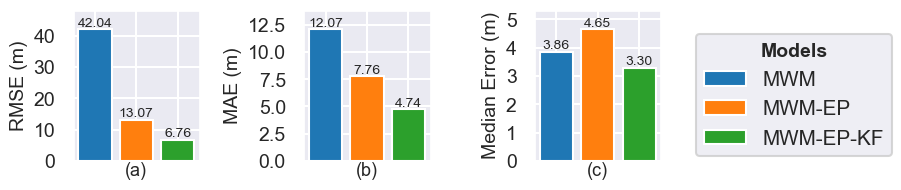

In [141]:
# Define the subset of models to compare
model_subset = ['MWM', 'MWM-EP', 'MWM-EP-KF']

# Extract RMSE, MAE, Median Error values from your metrics dataframe
rmse_values   = metrics_df_neglected.loc['RMSE', model_subset]
mae_values    = metrics_df_neglected.loc['MAE', model_subset]
median_values = metrics_df_neglected.loc['Median Error', model_subset]

# Create subplots for RMSE, MAE, and Median Error
fig, axs = plt.subplots(1, 3, figsize=(7, 2.2))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

# (a) RMSE plot
bars_a = axs[0].bar(model_subset, rmse_values, color=colors)
axs[0].set_ylabel('RMSE (m)', fontsize=14)
axs[0].tick_params(axis='x', bottom=False, labelbottom=False)
axs[0].tick_params(axis='y', labelsize=14)
axs[0].text(0.5, -0.1, '(a)', transform=axs[0].transAxes,
            fontsize=13, ha='center')
for bar, label in zip(bars_a, model_subset):
    bar.set_label(label)

# (b) MAE plot
bars_b = axs[1].bar(model_subset, mae_values, color=colors)
axs[1].set_ylabel('MAE (m)', fontsize=14)
axs[1].tick_params(axis='x', bottom=False, labelbottom=False)
axs[1].tick_params(axis='y', labelsize=14)
axs[1].text(0.5, -0.1, '(b)', transform=axs[1].transAxes,
            fontsize=13, ha='center')

# (c) Median Error plot
bars_c = axs[2].bar(model_subset, median_values, color=colors)
axs[2].set_ylabel('Median Error (m)', fontsize=14)
axs[2].tick_params(axis='x', bottom=False, labelbottom=False)
axs[2].tick_params(axis='y', labelsize=14)
axs[2].text(0.5, -0.1, '(c)', transform=axs[2].transAxes,
            fontsize=13, ha='center')

# Set each subplot's y-axis to have roughly 6 ticks
for ax in axs:
    ax.yaxis.set_major_locator(MaxNLocator(nbins=6))

# Set border (spine) width for both subplots and annotate bar values
for ax in axs:
    [s.set_linewidth(2) for s in ax.spines.values()]
    for bar in ax.patches:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    (bar.get_x() + bar.get_width() / 2, height),
                    ha='center', va='bottom', fontsize=10,
                    clip_on=True)
    # Add headroom for bar labels
    y_max = max(bar.get_height() for bar in ax.patches)
    ax.set_ylim(top=y_max * 1.15)  # 15% headroom

# Create a common legend on the right-hand side with one column
handles, labels = axs[0].get_legend_handles_labels()
legend = fig.legend(handles, labels, loc='center left',
                    bbox_to_anchor=(1.0, 0.5), ncol=1, title='Models')
legend.get_title().set_fontsize(14)
legend.get_title().set_fontweight('bold')

# Adjust layout to make room for the right-hand side legend
plt.subplots_adjust(right=0.85, bottom=0.15)
plt.tight_layout()
plt.savefig('../all_data_files/Localization/distance_rmse_mae_median_comparison.png',
            dpi=2000, bbox_inches='tight')
plt.show()

In [142]:
# ----------------------------------------------------
# Compute absolute errors and CDF for both models
# ----------------------------------------------------

def compute_cdf(errors, bins=100):
    hist_vals, bin_edges = np.histogram(errors, bins=bins, density=True)
    cdf_vals = np.cumsum(hist_vals * np.diff(bin_edges))
    return bin_edges[1:], cdf_vals

error_A_raw  = np.abs(true_distance - d_A_raw)
error_A_filt = np.abs(true_distance - d_A_filt)
error_B_raw  = np.abs(true_distance - d_B_raw)
error_B_filt = np.abs(true_distance - d_B_filt)

x_A_raw,  cdf_A_raw  = compute_cdf(error_A_raw)
x_A_filt, cdf_A_filt = compute_cdf(error_A_filt)
x_B_raw,  cdf_B_raw  = compute_cdf(error_B_raw)
x_B_filt, cdf_B_filt = compute_cdf(error_B_filt)

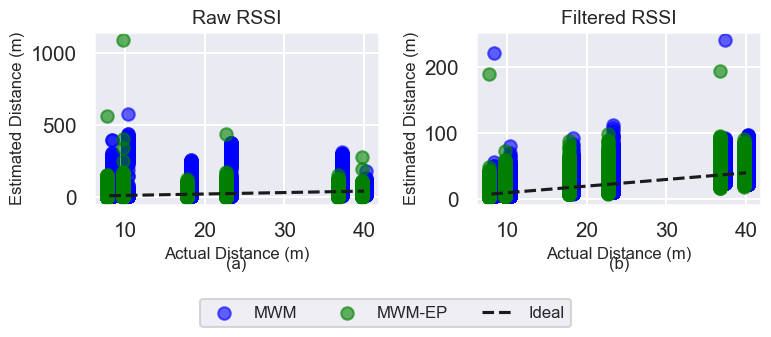

In [143]:
# -------------------------------------------------------
# Scatter Plots (2x1 for estimated vs actual distance)
# -------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(8, 3.5))

# Define a jitter value for visual separation
jitter = 0.3

def plot_scatter(ax, actual, pred_A, pred_B, title):
    # Add jitter to actual distances for MWM and Model B
    ax.scatter(actual + jitter, pred_A, alpha=0.6, label='MWM', color='blue')
    ax.scatter(actual - jitter, pred_B, alpha=0.6, label='MWM-EP', color='green')
    ax.plot([actual.min(), actual.max()], [actual.min(), actual.max()], 'k--', label='Ideal')
    ax.set_xlabel('Actual Distance (m)', fontsize=12)
    ax.set_ylabel('Estimated Distance (m)', fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.grid(True)

# Plot scatter for Raw RSSI and Filtered RSSI
plot_scatter(axes[0], true_distance, d_A_raw, d_B_raw, 'Raw RSSI')
plot_scatter(axes[1], true_distance, d_A_filt, d_B_filt, 'Filtered RSSI')

# Add subplot labels (a) and (b) below each subplot
axes[0].text(0.5, -0.3, '(a)', transform=axes[0].transAxes,
             fontsize=12, ha='center', va='top')
axes[1].text(0.5, -0.3, '(b)', transform=axes[1].transAxes,
             fontsize=12, ha='center', va='top')

# Collect handles/labels from both subplots
handles_a, labels_a = axes[0].get_legend_handles_labels()
handles_b, labels_b = axes[1].get_legend_handles_labels()
all_handles = handles_a + handles_b
all_labels = labels_a + labels_b

# Remove duplicate legend entries while preserving order
seen = {}
unique_handles = []
unique_labels = []
for h, lbl in zip(all_handles, all_labels):
    if lbl not in seen:
        unique_handles.append(h)
        unique_labels.append(lbl)
        seen[lbl] = True

# Create a single combined legend below the subplots
fig.legend(unique_handles, unique_labels, loc='lower center', bbox_to_anchor=(0.5, 0.0), ncol=3, fontsize=12)

# Adjust layout to include legend space and save the figure
plt.tight_layout(rect=[0, 0.03, 1, 1])
plt.savefig('../all_data_files/Localization/distance_scatter.png', dpi=1000, bbox_inches='tight')
plt.show()

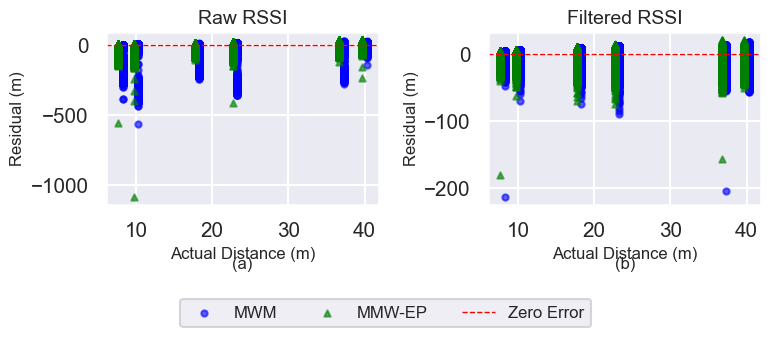

In [144]:
# Create subplots (1 row, 2 columns) for residuals vs actual distance
fig, axes = plt.subplots(1, 2, figsize=(8, 3.5))

# Compute residuals for Raw and Filtered RSSI
resid_A_raw  = true_distance - d_A_raw
resid_B_raw  = true_distance - d_B_raw
resid_A_filt = true_distance - d_A_filt
resid_B_filt = true_distance - d_B_filt

# Define function to plot residuals with jitter
def plot_residuals(ax, actual, resid_A, resid_B, title, jitter=0.3):
    # Add jitter to actual distances for Model A and Model B residuals
    ax.scatter(actual + jitter, resid_A, alpha=0.6, s=20, color='blue', marker='o', label='MWM')
    ax.scatter(actual - jitter, resid_B, alpha=0.6, s=20, color='green', marker='^', label='MMW-EP')
    ax.axhline(0, color='red', linestyle='--', linewidth=1, label='Zero Error')
    ax.set_xlabel('Actual Distance (m)', fontsize=12)
    ax.set_ylabel('Residual (m)', fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.grid(True)

# Plot residuals for Raw and Filtered RSSI
plot_residuals(axes[0], true_distance, resid_A_raw, resid_B_raw, 'Raw RSSI')
plot_residuals(axes[1], true_distance, resid_A_filt, resid_B_filt, 'Filtered RSSI')

# Add subplot labels (a) and (b) below each subplot
axes[0].text(0.5, -0.3, '(a)', transform=axes[0].transAxes,
             fontsize=12, ha='center', va='top')
axes[1].text(0.5, -0.3, '(b)', transform=axes[1].transAxes,
             fontsize=12,  ha='center', va='top')

# Collect handles and labels from both subplots
handles_a, labels_a = axes[0].get_legend_handles_labels()
handles_b, labels_b = axes[1].get_legend_handles_labels()
all_handles = handles_a + handles_b
all_labels = labels_a + labels_b

# Remove duplicate legend entries while preserving order
seen = {}
unique_handles = []
unique_labels = []
for h, lbl in zip(all_handles, all_labels):
    if lbl not in seen:
        unique_handles.append(h)
        unique_labels.append(lbl)
        seen[lbl] = True

# Create a single combined legend below the subplots
fig.legend(unique_handles, unique_labels, loc='lower center', bbox_to_anchor=(0.5, 0.0), ncol=3, fontsize=12)

# Adjust layout to include space for the legend
plt.tight_layout(rect=[0, 0.03, 1, 1])
plt.show()

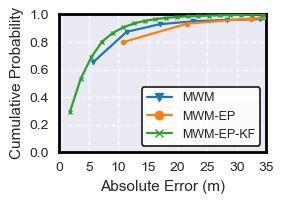

In [145]:
# ----------------------------
# Configurable font sizes
# ----------------------------
FS_LABEL  = 11
FS_TICK   = 10
FS_LEGEND = 9

# ----------------------------
# Colors
# ----------------------------
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

sns.set_theme(style="darkgrid")  

plt.figure(figsize=(3,2.2))
ax = plt.gca()

ax.plot(x_A_raw,  cdf_A_raw,  label='MWM',       color=colors[0], marker='v', markersize=3, linewidth=1.6, zorder=3)
#plt.plot(x_A_filt, cdf_A_filt, label='MWM-KF', color='green',  marker='^', markersize=3)
ax.plot(x_B_raw,  cdf_B_raw,  label='MWM-EP',    color=colors[1], marker='o', markersize=3, linewidth=1.6, zorder=3)
ax.plot(x_B_filt, cdf_B_filt, label='MWM-EP-KF', color=colors[2], marker='x', markersize=3, linewidth=1.6, zorder=3)

# Labels and limits
ax.set_xlabel('Absolute Error (m)', fontsize=FS_LABEL)
ax.set_ylabel('Cumulative Probability', fontsize=FS_LABEL)
ax.set_xlim(0, 35)
ax.set_ylim(0, 1)

# Ticks
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax.tick_params(axis='both', which='major', labelsize=FS_TICK, width=1.2, length=4)

# Grid and legend
ax.grid(True, linestyle='--', alpha=0.7)
leg = ax.legend(loc='lower right', fontsize=FS_LEGEND, markerscale=2, frameon=True)
# Make legend frame readable on darkgrid
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_linewidth(1.2)
leg.get_frame().set_facecolor('white')
leg.get_frame().set_alpha(0.9)

for side in ['left', 'right', 'bottom', 'top']:
    sp = ax.spines[side]
    sp.set_visible(True)        
    sp.set_linewidth(2.0)
    sp.set_edgecolor('black')

plt.tight_layout()
plt.savefig('../all_data_files/Localization/cdf_errors.png',
            dpi=1000, bbox_inches='tight', facecolor='white')  # white background helps borders pop
plt.show()


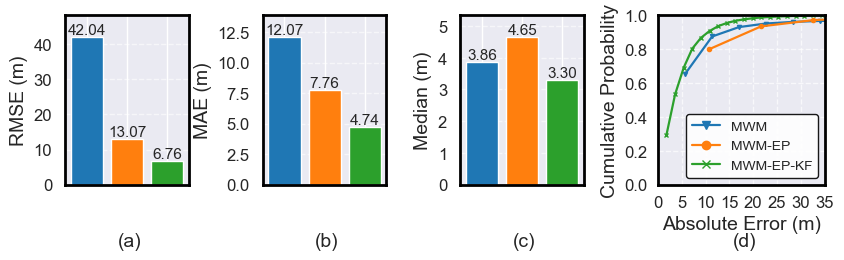

In [146]:
# ============================================
# 1×4: RMSE | MAE | Median | CDF (shared key)
# ============================================

# Tunable typography
FS_LABEL  = 14
FS_TICK   = 12
FS_LEGEND = 10
FS_ANN    = 11 

# Palette (consistent across panels)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
model_subset = ['MWM', 'MWM-EP', 'MWM-EP-KF']

# Pull metrics from your DataFrame
rmse_values   = metrics_df_neglected.loc['RMSE', model_subset]
mae_values    = metrics_df_neglected.loc['MAE', model_subset]
median_values = metrics_df_neglected.loc['Median Error', model_subset]

# Theme
sns.set_theme(style="darkgrid")

# Layout:
# give the CDF a bit more horizontal space than each bar panel
fig, axs = plt.subplots(
    1, 4, figsize=(9.8, 2.2),
    gridspec_kw={'width_ratios': [1.0, 1.0, 1.0, 1.35], 'wspace': 0.55}
)

# Helper for bar panels
def make_bar_panel(ax, values, ylabel, panel_tag):
    bars = ax.bar(model_subset, values, color=colors, zorder=3)
    ax.set_ylabel(ylabel, fontsize=FS_LABEL)
    ax.tick_params(axis='x', bottom=False, labelbottom=False)
    ax.tick_params(axis='y', labelsize=FS_TICK)
    ax.yaxis.set_major_locator(MaxNLocator(nbins=6))
    ax.grid(True, axis='y', linestyle='--', alpha=0.6, zorder=0)

    # annotate bars + headroom
    for b in bars:
        h = b.get_height()
        ax.annotate(f'{h:.2f}', (b.get_x()+b.get_width()/2, h),
                    ha='center', va='bottom', fontsize=FS_ANN, clip_on=True)
    ymax = max(b.get_height() for b in bars) if len(bars) else 1.0
    ax.set_ylim(top=ymax * 1.15)

    # panel tag
    ax.text(0.52, -0.28, panel_tag, transform=ax.transAxes,
            fontsize=FS_LABEL, ha='center', va='top')

# (a) RMSE
make_bar_panel(axs[0], rmse_values, 'RMSE (m)', '(a)')
# (b) MAE
make_bar_panel(axs[1], mae_values, 'MAE (m)', '(b)')
# (c) Median
make_bar_panel(axs[2], median_values, 'Median (m)', '(c)')

# (d) CDF
ax = axs[3]
ax.plot(x_A_raw,  cdf_A_raw,  label='MWM',       color=colors[0], marker='v', markersize=3, linewidth=1.6, zorder=3)
ax.plot(x_B_raw,  cdf_B_raw,  label='MWM-EP',    color=colors[1], marker='o', markersize=3, linewidth=1.6, zorder=3)
ax.plot(x_B_filt, cdf_B_filt, label='MWM-EP-KF', color=colors[2], marker='x', markersize=3, linewidth=1.6, zorder=3)

ax.set_xlabel('Absolute Error (m)', fontsize=FS_LABEL)
ax.set_ylabel('Cumulative Probability', fontsize=FS_LABEL)
ax.set_xlim(0, 35)
ax.set_ylim(0, 1)

ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax.tick_params(axis='both', which='major', labelsize=FS_TICK, width=1.0, length=4)
ax.grid(True, linestyle='--', alpha=0.7, zorder=0)

# Legend INSIDE panel (d) serves as the shared key
leg = ax.legend(loc='lower right', fontsize=FS_LEGEND, frameon=True, markerscale=2)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_linewidth(1.0)
leg.get_frame().set_facecolor('white')
leg.get_frame().set_alpha(0.9)

# panel tag
ax.text(0.52, -0.28, '(d)', transform=ax.transAxes,
        fontsize=FS_LABEL, ha='center', va='top')

# Force solid black spines across all panels (do this last)
for a in axs:
    for s in a.spines.values():
        s.set_visible(True)
        s.set_linewidth(2.0)
        s.set_color('black')
        s.set_zorder(10)

# fig.tight_layout()
plt.savefig('../all_data_files/Localization/metrics_plus_cdf_1x4.png',
            dpi=1200, bbox_inches='tight', facecolor='white')
plt.show()

In [147]:
# Compute Relative Errors (%) explicitly per device

# Combine necessary data into one DataFrame
error_df = test_df[['device_id', 'distance']].copy()

# Calculate relative errors (%)
error_df['MWM'] = 100 * np.abs(true_distance - d_A_raw) / true_distance
error_df['MWM-KF'] = 100 * np.abs(true_distance - d_A_filt) / true_distance
error_df['MWM-EP'] = 100 * np.abs(true_distance - d_B_raw) / true_distance
error_df['MWM-EP-KF'] = 100 * np.abs(true_distance - d_B_filt) / true_distance

# Define the IQR filtering function
def filter_outliers_iqr(df, cols, multiplier=1.5):
    filtered_df = df.copy()
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - multiplier * IQR
        upper_bound = Q3 + multiplier * IQR
        filtered_df = filtered_df[(filtered_df[col] >= lower_bound) & (filtered_df[col] <= upper_bound)]
    return filtered_df

# Using 'error_df' 
cols_to_check = ['MWM', 'MWM-KF', 'MWM-EP', 'MWM-EP-KF']
iqr_filtered_df = filter_outliers_iqr(error_df, cols_to_check)

# Compute mean relative errors per device after robust IQR filtering
mean_errors_per_device = iqr_filtered_df.groupby('device_id')[cols_to_check].mean().round(2)

# Compute overall mean relative errors across all devices
overall_mean_errors = iqr_filtered_df[cols_to_check].mean().round(2)

# Display results 
print("\nMean Relative Errors (%) per Device:\n")
display(mean_errors_per_device)
print("\nOverall Mean Relative Errors (%):\n")
print(overall_mean_errors)


Mean Relative Errors (%) per Device:



,MWM,MWM-KF,MWM-EP,MWM-EP-KF
device_id,,,,
ED0,21.62,19.76,27.36,19.84
ED1,21.75,19.69,27.39,19.59
ED2,19.11,17.83,26.89,18.32
ED3,28.58,23.11,27.74,21.79
ED4,15.67,13.53,25.53,14.13
ED5,20.38,17.59,22.72,15.58



Overall Mean Relative Errors (%):

MWM          21.13
MWM-KF       18.52
MWM-EP       26.18
MWM-EP-KF    18.11
dtype: float64


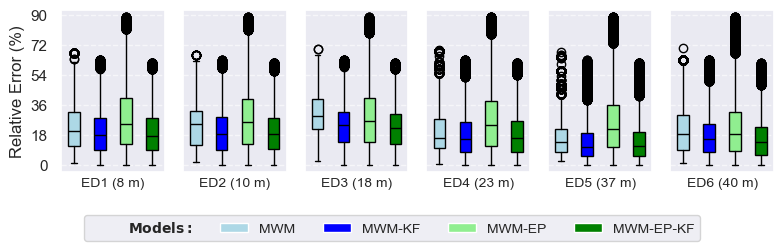

In [148]:
# Box plot visualization for relative errors per device (with IQR filtering)

# Define the IQR filtering function

def filter_outliers_iqr(df, cols, multiplier=1.5):
    """    
    Parameters:
    -----------
    df : pd.DataFrame
        The input DataFrame containing error columns to be filtered.
    cols : list of str
        The column names in `df` on which to apply the IQR filtering.
    multiplier : float, optional (default=1.5)
        The multiplier for the IQR to determine outlier boundaries.
        
    Returns:
    --------
    filtered_df : pd.DataFrame
        A copy of the input DataFrame with outliers removed based on IQR filtering.
    """
    filtered_df = df.copy()
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - multiplier * IQR
        upper_bound = Q3 + multiplier * IQR
        filtered_df = filtered_df[(filtered_df[col] >= lower_bound) & (filtered_df[col] <= upper_bound)]
    return filtered_df

# Apply filtering to error_df
cols_to_check = ['MWM', 'MWM-KF', 'MWM-EP', 'MWM-EP-KF']
robust_relative_error_df = filter_outliers_iqr(error_df, cols_to_check)

# Create one row of 6 subplots
fig, axes = plt.subplots(1, 6, figsize=(8, 2.4), sharey=True)

# Sort devices by mean distance
devices_sorted = robust_relative_error_df.groupby('device_id')['distance'].mean().sort_values().index

# Define box colors (for consistency in plotting and legend)
box_colors = ['lightblue', 'blue', 'lightgreen', 'green']

# Loop through each device and plot 4 boxplots (Raw A, Filtered A, Raw B, Filtered B)
for idx, device in enumerate(devices_sorted):
    device_data = robust_relative_error_df[robust_relative_error_df['device_id'] == device]
    
    data_to_plot = [
        device_data['MWM'],
        device_data['MWM-KF'],
        device_data['MWM-EP'],
        device_data['MWM-EP-KF']
    ]
    
    bp = axes[idx].boxplot(
        data_to_plot,
        patch_artist=True,
        medianprops=dict(color='black')
    )
    
    # Color the boxes using the defined colors
    for patch, color in zip(bp['boxes'], box_colors):
        patch.set_facecolor(color)
    
    # Remove numeric x-tick labels so only the device label appears
    axes[idx].set_xticks([])
    axes[idx].set_xticklabels([])

    # Set device label as the x-axis label (e.g., "ED1 (8 m)")
    distance_val = int(device_data["distance"].iloc[0])
    axes[idx].set_xlabel(f'ED{idx+1} ({distance_val} m)', fontsize=10)
    
    # Only the first subplot gets a y-axis label to avoid repetition
    if idx == 0:
        axes[idx].set_ylabel('Relative Error (%)')
    else:
        axes[idx].set_ylabel('')
    
    # Add grid for readability
    axes[idx].grid(True, linestyle='--', alpha=0.6)

# --- Create a single inline legend for the entire figure ---
# Create a dummy handle for the inline title "Models:" (displayed in bold using mathtext)
dummy_handle = mpatches.Patch(color='none', label=r'$\mathbf{Models:}$')
# Create handles for the four model entries
model_handles = [plt.Rectangle((0, 0), 1, 1, facecolor=color) for color in box_colors]
# Combine the dummy handle with the actual model handles
handles = [dummy_handle] + model_handles
labels = [r'$\mathbf{Models:}$', 'MWM', 'MWM-KF', 'MWM-EP', 'MWM-EP-KF']
# Position the legend in one row at the bottom of the figure
fig.legend(handles, labels, fontsize=10, loc='upper center', 
           bbox_to_anchor=(0.5, 0.1), ncol=5)

# Set y-axis ticks: using MultipleLocator to set the tick spacing to 18 (adjust if needed)
for ax in axes:
    ax.yaxis.set_major_locator(ticker.MultipleLocator(18))

# Adjust layout to make room for the legend and labels
plt.tight_layout(rect=[0, 0.1, 1, 1])
plt.show()

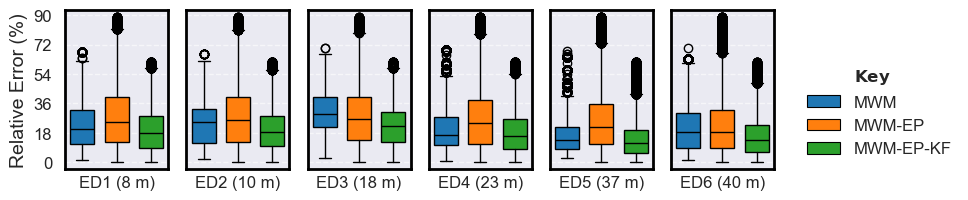

In [149]:
# Box plot visualization for relative errors per device (with IQR filtering)

def filter_outliers_iqr(df, cols, multiplier=1.5):
    """IQR filter for specified columns."""
    filtered_df = df.copy()
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - multiplier * IQR
        upper_bound = Q3 + multiplier * IQR
        filtered_df = filtered_df[(filtered_df[col] >= lower_bound) & (filtered_df[col] <= upper_bound)]
    return filtered_df

# Apply filtering
cols_to_check = ['MWM', 'MWM-KF', 'MWM-EP', 'MWM-EP-KF']
robust_relative_error_df = filter_outliers_iqr(error_df, cols_to_check)

# Figure
fig, axes = plt.subplots(1, 6, figsize=(8, 2.4), sharey=True)

# Colors used for all devices and legend
box_colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

# Devices sorted by mean distance
devices_sorted = robust_relative_error_df.groupby('device_id')['distance'].mean().sort_values().index

# Plot per device
for idx, device in enumerate(devices_sorted[:6]):  # guard in case >6 devices
    ax = axes[idx]
    device_data = robust_relative_error_df[robust_relative_error_df['device_id'] == device]

    data_to_plot = [
        device_data['MWM'],        # Raw A
        device_data['MWM-EP'],     # Raw B
        device_data['MWM-EP-KF']   # Filtered B
    ]

    bp = ax.boxplot(
        data_to_plot,
        patch_artist=True,
        medianprops=dict(color='black'),
        widths=0.7
    )

    # Fill box faces with your palette
    for patch, color in zip(bp['boxes'], box_colors):
        patch.set_facecolor(color)

    # Clean x ticks; label with device + distance
    ax.set_xticks([])
    ax.set_xticklabels([])
    distance_val = int(device_data["distance"].iloc[0])
    ax.set_xlabel(f'ED{idx+1} ({distance_val} m)', fontsize=12)

    # Only left subplot gets y-label
    if idx == 0:
        ax.set_ylabel('Relative Error (%)', fontsize=14)
    else:
        ax.set_ylabel('')

    # Grid and ticks
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.tick_params(axis='y', labelsize=12)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(18))

    # Force black spines for this axis
    for side in ('left', 'right', 'bottom', 'top'):
        sp = ax.spines[side]
        sp.set_visible(True)
        sp.set_linewidth(2)
        sp.set_color('black')
        sp.set_zorder(10)

# Legend on the right
dummy_handle = mpatches.Patch(facecolor='none', edgecolor='none', label=r'$\mathbf{Key}$')
colored_handles = [mpatches.Patch(facecolor=c, edgecolor='black', linewidth=0.8) for c in box_colors]
handles = [dummy_handle] + colored_handles
labels = [r'$\mathbf{Key}$', 'MWM', 'MWM-EP', 'MWM-EP-KF']
fig.legend(handles, labels, fontsize=12, loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1, frameon=False)

plt.tight_layout(rect=[0, 0.1, 1, 1])
fig.patch.set_facecolor('white')  # keeps borders crisp on export
plt.savefig('../all_data_files/Localization/relative_errors_boxplots_per_device.png', dpi=2000, bbox_inches='tight', facecolor=fig.get_facecolor())
plt.show()
